# Doc embedding evaluation (315 repositories / train set)

## 1. Loading repository information

In [1]:
!pip install gdown
!gdown 1sJDBLvVRvl4Sx0ICGuoM27pREIg0M756

Downloading...
From (uriginal): https://drive.google.com/uc?id=1sJDBLvVRvl4Sx0ICGuoM27pREIg0M756
From (redirected): https://drive.google.com/uc?id=1sJDBLvVRvl4Sx0ICGuoM27pREIg0M756&confirm=t&uuid=621a461c-60ce-4c10-9138-e2c67c4cd31b
To: /cs/home/hz65/PycharmProjects/RepoSim4Py/Embedding/Embedding_model_train_315/Doc_embedding_evaluation_train_315/repo_info_train.pkl
100%|████████████████████████████████████████| 201M/201M [00:05<00:00, 37.1MB/s]


In [2]:
import pickle

with open("repo_info_train.pkl", "rb") as f:
    repo_info = pickle.load(f)
    f.close()

## 2. Download pre-trained model

In [3]:
!pip3 install torch
!pip3 install transformers
!pip3 install sentence-transformers
# !wget https://raw.githubusercontent.com/microsoft/CodeBERT/master/UniXcoder/unixcoder.py
!curl -O https://raw.githubusercontent.com/microsoft/CodeBERT/master/UniXcoder/unixcoder.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10352  100 10352    0     0  44239      0 --:--:-- --:--:-- --:--:-- 44239


In [4]:
import torch

# device = (
#     "cuda"
#     if torch.cuda.is_available()
#     else "mps"
#     if torch.backends.mps.is_available()
#     else "cpu"
# )
device = "cpu"
print(device)

cpu


In [5]:
unixcoder_model_names = [
    "microsoft/unixcoder-base-nine",
    "microsoft/unixcoder-base",
    "microsoft/unixcoder-base-unimodal",
    "Lazyhope/unixcoder-nine-advtest",
    "Lazyhope/unixcoder-clone-detection",
    "Enoch/Unixcoder-Tuned-Code-Search-Py"
]
sentence_transformer_model_names = [
    "sentence-transformers/all-mpnet-base-v2",
    "sentence-transformers/multi-qa-mpnet-base-cos-v1",
    "sentence-transformers/bert-base-nli-mean-tokens",
    "sentence-transformers/paraphrase-multilingual-mpnet-base-v2",
    "sentence-transformers/all-distilroberta-v1",
    "sentence-transformers/distilbert-base-nli-mean-tokens"
]
bert_model_names = [
    "Enoch/cocosoda-graphcodebert",
    "Enoch/graphcodebert-py"
]

In [6]:
from unixcoder import UniXcoder
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModel

unixcoder_models = {}
sentence_transformer_models = {}
bert_models = {}

# Initialise unixcoder model
for u_name in unixcoder_model_names:
    unixcoder_models[u_name] = UniXcoder(u_name)
    unixcoder_models[u_name].to(device)

# Initialise sentence transformer model
for s_name in sentence_transformer_model_names:
    sentence_transformer_models[s_name] = SentenceTransformer(model_name_or_path=s_name, device=device)

# Initialise GraphCodeBERT model
for b_name in bert_model_names:
    bert_models[b_name] = {}
    bert_models[b_name]["tokenizer"] = AutoTokenizer.from_pretrained(b_name, device=device)
    bert_models[b_name]["model"] = AutoModel.from_pretrained(b_name)

/cs/home/hz65/python/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 3. Generating doc embeddings

In [7]:
# Getting doc embeddings
def get_unixcoder_embeddings(data, model):
    tokens_ids = model.tokenize([data], max_length=512, mode="<encoder-only>")
    source_ids = torch.tensor(tokens_ids).to(device)
    _, embeddings = model(source_ids)
    return embeddings

# Getting doc embeddings by GraphCodeBERT
def get_bert_embeddings(data, bert_dict):
    tokenizer = bert_dict["tokenizer"]
    model = bert_dict["model"]
    inputs = tokenizer(data, padding=True, truncation=True, max_length=512, return_tensors="pt",)
    outputs = model(**inputs)
    embeddings = torch.mean(outputs.last_hidden_state, dim=1)
    return embeddings

# Getting other embbeddings
def get_other_embeddings(data_list):
    embeddings = {}
    
    # Unixcoder model
    for u_name, u_model in tqdm(unixcoder_models.items()):
        print(f" - Using {u_name} model - ")
        embeddings_list = torch.concat([get_unixcoder_embeddings(data, u_model) for data in data_list])
        embeddings[u_name] = embeddings_list
    
    # Sentence transformer model
    for s_name, s_model in tqdm(sentence_transformer_models.items()):
        print(f" - Using {s_name} model - ")
        embeddings_list = s_model.encode(data_list, convert_to_tensor=True)
        embeddings[s_name] = embeddings_list
    
    # Using GraphCodeBERT model
    for b_name, b_dict in tqdm(bert_models.items()):
        print(f" - Using {b_name} model - ")
        embeddings_list = torch.concat([get_bert_embeddings(data, b_dict) for data in data_list])
        embeddings[b_name] = embeddings_list
    
    
    return embeddings


# Getting embeddings
def get_embeddings(input_data=None, input_mode=None):
    if input_data is None or not input_data:
        return torch.zeros((768,), device=device)
    
    with torch.no_grad():
        if input_mode == "docs":
            return get_other_embeddings(input_data)


In [8]:
from tqdm import tqdm

for repo_name, repo_dict in tqdm(repo_info.items()):
    print(f" - Generating doc embeddings for {repo_name} - ")
    repo_dict["docs_embeddings"] = get_embeddings(input_data=repo_dict["docs"], input_mode="docs")

  0%|                                                   | 0/315 [00:00<?, ?it/s]

 - Generating doc embeddings for jet-admin/jet-bridge - 



 33%|███████████████                              | 2/6 [00:00<00:00, 15.91it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 15.58it/s]


 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 33%|███████████████                              | 2/6 [00:00<00:00, 17.66it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 17.33it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 19.77it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|▏                                          | 1/315 [00:00<04:13,  1.24it/s]

 - Using Enoch/cocosoda-graphcodebert model - 
 - Using Enoch/graphcodebert-py model - 
 - Generating doc embeddings for patrys/httmock - 
 - Generating doc embeddings for pytransitions/transitions - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:08,  1.67s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.64s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.63s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:03,  1.62s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:08<00:01,  1.61s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:09<00:00,  1.63s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:06<00:31,  6.31s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:15<00:31,  7.86s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:17<00:15,  5.08s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:18<00:07,  3.79s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:23<00:03,  3.94s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:23<00:00,  3.99s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:01<00:01,  1.55s/it]

 - Using Enoch/graphcodebert-py model - 



  1%|▍                                        | 3/315 [00:37<1:11:57, 13.84s/it]

 - Generating doc embeddings for keleshev/schema - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.24it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.32it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.35it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.37it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  2.38it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.36it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.43it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.43it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.45it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.34it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.39it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.53it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.27it/s]

 - Using Enoch/graphcodebert-py model - 



  1%|▌                                        | 4/315 [00:44<1:00:03, 11.59s/it]

 - Generating doc embeddings for dylanaraps/pywal - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:09,  2.00s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:07,  1.96s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:05,  1.99s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:03,  2.00s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:09<00:01,  2.00s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:11<00:00,  1.99s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:04,  1.19it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.24it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.26it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.24it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.53it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:04<00:00,  1.49it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:01<00:01,  1.92s/it]

 - Using Enoch/graphcodebert-py model - 



  2%|▋                                        | 5/315 [01:04<1:13:54, 14.31s/it]

 - Generating doc embeddings for PyCQA/modernize - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.03it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.04it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.97it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  3.97it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  3.94it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.95it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  2.53it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.54it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.51it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.25it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  2.71it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.76it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  4.02it/s]

 - Using Enoch/graphcodebert-py model - 



  2%|▊                                          | 6/315 [01:08<56:57, 11.06s/it]

 - Generating doc embeddings for jaraco/path.py - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.18it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.08it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.80it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  3.98it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  3.99it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.03it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:05,  1.05s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:02<00:04,  1.04s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.28it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.50it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.76it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.64it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  4.48it/s]

 - Using Enoch/graphcodebert-py model - 



  2%|▉                                          | 7/315 [01:14<48:03,  9.36s/it]

 - Generating doc embeddings for xonsh/xonsh - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:12<01:04, 12.82s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:25<00:51, 12.76s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:37<00:37, 12.48s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:49<00:24, 12.33s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:04<00:13, 13.02s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [01:19<00:00, 13.24s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:13<01:05, 13.02s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:25<00:50, 12.60s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:33<00:32, 10.69s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:43<00:20, 10.13s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:50<00:09,  9.09s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:54<00:00,  9.09s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:12<00:12, 12.07s/it]

 - Using Enoch/graphcodebert-py model - 



  3%|█                                        | 8/315 [03:52<4:43:43, 55.45s/it]

 - Generating doc embeddings for python-excel/xlrd - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.46it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.47it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.48it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.50it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  2.51it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.50it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.74it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  3.75it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.75it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.54it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.47it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.52it/s]

 - Using Enoch/graphcodebert-py model - 



  3%|█▏                                       | 9/315 [03:57<3:23:08, 39.83s/it]

 - Generating doc embeddings for cloudnativelabs/kube-shell - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  7.10it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  7.10it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00,  7.07it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  7.06it/s]

 33%|███████████████                              | 2/6 [00:00<00:00, 16.02it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 17.66it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  6.34it/s]

 - Using Enoch/graphcodebert-py model - 



  3%|█▎                                      | 10/315 [03:58<2:23:04, 28.15s/it]

 - Generating doc embeddings for ironmussa/Optimus - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:12<01:01, 12.33s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:24<00:48, 12.20s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:36<00:36, 12.15s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:48<00:24, 12.11s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:00<00:12, 12.06s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [01:12<00:00, 12.10s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:09<00:48,  9.60s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:19<00:38,  9.59s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:26<00:25,  8.34s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:33<00:15,  7.83s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:37<00:06,  6.73s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:41<00:00,  6.90s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:11<00:11, 11.80s/it]

 - Using Enoch/graphcodebert-py model - 



  3%|█▍                                      | 11/315 [06:16<5:10:44, 61.33s/it]

 - Generating doc embeddings for jazzband/django-taggit - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  1.75it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.77it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.78it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.78it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  1.79it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.78it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:06,  1.37s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:02<00:05,  1.39s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.38s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.41s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:06<00:01,  1.17s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.17s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  1.84it/s]

 - Using Enoch/graphcodebert-py model - 



  4%|█▌                                      | 12/315 [06:27<3:53:38, 46.27s/it]

 - Generating doc embeddings for moggers87/salmon - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:05<00:26,  5.35s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:10<00:21,  5.31s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:15<00:15,  5.29s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:21<00:10,  5.27s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:26<00:05,  5.26s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:31<00:00,  5.27s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:06<00:32,  6.43s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:12<00:25,  6.42s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:16<00:15,  5.27s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:20<00:09,  4.77s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:24<00:04,  4.47s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:26<00:00,  4.44s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:05<00:05,  5.20s/it]

 - Using Enoch/graphcodebert-py model - 



  4%|█▋                                      | 13/315 [07:36<4:26:51, 53.02s/it]

 - Generating doc embeddings for glamp/bashplotlib - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  7.94it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  8.06it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00,  8.13it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.06it/s]

 33%|███████████████                              | 2/6 [00:00<00:00, 15.54it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 18.84it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  8.40it/s]

 - Using Enoch/cocosoda-graphcodebert model - 
 - Using Enoch/graphcodebert-py model - 



  4%|█▊                                      | 14/315 [07:37<3:07:52, 37.45s/it]

 - Generating doc embeddings for PyCQA/prospector - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:06,  1.26s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:04,  1.25s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.25s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:02,  1.24s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:06<00:01,  1.24s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.24s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:10,  2.14s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:04<00:08,  2.14s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:06,  2.02s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:03,  1.97s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:09<00:01,  1.68s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:10<00:00,  1.70s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:01<00:01,  1.21s/it]

 - Using Enoch/graphcodebert-py model - 



  5%|█▉                                      | 15/315 [07:57<2:41:05, 32.22s/it]

 - Generating doc embeddings for twisted/treq - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:05<00:26,  5.38s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:10<00:21,  5.36s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:16<00:16,  5.43s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:21<00:10,  5.44s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:27<00:05,  5.40s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:32<00:00,  5.38s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:04<00:22,  4.60s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:09<00:18,  4.59s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:13<00:13,  4.37s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:17<00:08,  4.37s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:19<00:03,  3.57s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:21<00:00,  3.65s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:05<00:05,  5.14s/it]

 - Using Enoch/graphcodebert-py model - 



  5%|██                                      | 16/315 [09:02<3:28:53, 41.92s/it]

 - Generating doc embeddings for bbangert/beaker - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:09,  1.99s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:07,  1.96s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:05,  1.94s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:03,  1.93s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:09<00:01,  1.92s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:11<00:00,  1.93s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:06<00:32,  6.60s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:13<00:26,  6.67s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:15<00:13,  4.58s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:17<00:07,  3.61s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:21<00:03,  3.89s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:23<00:00,  3.83s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:01<00:01,  1.96s/it]

 - Using Enoch/graphcodebert-py model - 



  5%|██▏                                     | 17/315 [09:40<3:23:07, 40.90s/it]

 - Generating doc embeddings for pypa/bandersnatch - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:04,  1.17it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.18it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.18it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.19it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:04<00:00,  1.19it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:05<00:00,  1.19it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.31it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.36it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.38it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.41it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.69it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.66it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  1.18it/s]

 - Using Enoch/graphcodebert-py model - 



  6%|██▎                                     | 18/315 [09:51<2:37:02, 31.73s/it]

 - Generating doc embeddings for zachwill/moment - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  1.74it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.76it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.77it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.78it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  1.79it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.78it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  2.98it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.97it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.96it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  3.62it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.51it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  1.83it/s]

 - Using Enoch/graphcodebert-py model - 



  6%|██▍                                     | 19/315 [09:57<1:58:40, 24.06s/it]

 - Generating doc embeddings for encode/apistar - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  1.83it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.89it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.90it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.92it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  1.93it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.92it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:04,  1.20it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.20it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.19it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.24it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.56it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:04<00:00,  1.48it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  1.93it/s]

 - Using Enoch/graphcodebert-py model - 



  6%|██▌                                     | 20/315 [10:05<1:34:53, 19.30s/it]

 - Generating doc embeddings for pyinvoke/invoke - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:06<00:32,  6.56s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:13<00:26,  6.51s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:19<00:19,  6.48s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:25<00:12,  6.47s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:32<00:06,  6.45s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:38<00:00,  6.46s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:09<00:45,  9.19s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:20<00:42, 10.70s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:25<00:23,  7.92s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:30<00:13,  6.58s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:35<00:06,  6.23s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:38<00:00,  6.34s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:06<00:06,  6.52s/it]

 - Using Enoch/graphcodebert-py model - 



  7%|██▋                                     | 21/315 [11:35<3:18:23, 40.49s/it]

 - Generating doc embeddings for skorokithakis/shortuuid - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.76it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  3.77it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.80it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  3.82it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  3.84it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.82it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.09it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  3.21it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.26it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  3.79it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.74it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.88it/s]

 - Using Enoch/graphcodebert-py model - 



  7%|██▊                                     | 22/315 [11:39<2:23:47, 29.45s/it]

 - Generating doc embeddings for s3tools/s3cmd - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:04,  1.14it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.15it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.16it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.16it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:04<00:00,  1.16it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:05<00:00,  1.16it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:12,  2.54s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:05<00:10,  2.54s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:06,  2.11s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:03,  1.90s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:09<00:01,  1.61s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:10<00:00,  1.69s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  1.16it/s]

 - Using Enoch/graphcodebert-py model - 



  7%|██▉                                     | 23/315 [11:56<2:05:12, 25.73s/it]

 - Generating doc embeddings for pyenv/pyenv - 



 33%|███████████████                              | 2/6 [00:00<00:00, 14.10it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 14.12it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 14.13it/s]

 33%|███████████████                              | 2/6 [00:00<00:00, 14.67it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 16.13it/s]


 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



  8%|███                                     | 24/315 [11:57<1:28:44, 18.30s/it]

 - Using Enoch/graphcodebert-py model - 
 - Generating doc embeddings for stchris/untangle - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.57it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  3.78it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.88it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  3.92it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  3.96it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.91it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:06,  1.25s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:02<00:04,  1.25s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:02,  1.08it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.30it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:04<00:00,  1.44it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:04<00:00,  1.36it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  4.01it/s]

 - Using Enoch/graphcodebert-py model - 



  8%|███▏                                    | 25/315 [12:03<1:11:16, 14.75s/it]

 - Generating doc embeddings for nvdv/vprof - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:07,  1.44s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:05,  1.42s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.41s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.40s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:07<00:01,  1.40s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:08<00:00,  1.41s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:05,  1.01s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.02it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.03it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.03it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:04<00:00,  1.25it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:04<00:00,  1.22it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:01<00:01,  1.38s/it]

 - Using Enoch/graphcodebert-py model - 



  8%|███▎                                    | 26/315 [12:19<1:13:16, 15.21s/it]

 - Generating doc embeddings for h2oai/h2o-3 - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:34<02:52, 34.56s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [01:08<02:15, 33.90s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [01:41<01:40, 33.64s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [02:14<01:07, 33.51s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [02:47<00:33, 33.41s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [03:21<00:00, 33.53s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:35<02:58, 35.63s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [01:13<02:27, 36.94s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [01:42<01:39, 33.29s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [02:11<01:03, 31.73s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [02:29<00:26, 26.80s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [02:44<00:00, 27.40s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:33<00:33, 33.02s/it]

 - Using Enoch/graphcodebert-py model - 



  9%|███▎                                  | 27/315 [19:31<11:12:26, 140.09s/it]

 - Generating doc embeddings for benhamner/Metrics - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:05,  1.01s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:04,  1.00s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:02,  1.00it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.00it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:04<00:00,  1.01it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:05<00:00,  1.00it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:12,  2.46s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:04<00:09,  2.46s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:06,  2.09s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:03,  1.93s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:09<00:01,  1.76s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:10<00:00,  1.76s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  1.02it/s]

 - Using Enoch/graphcodebert-py model - 



  9%|███▍                                   | 28/315 [19:49<8:15:34, 103.61s/it]

 - Generating doc embeddings for jmcarp/robobrowser - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.54it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.51it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.53it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.55it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.56it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.55it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  1.78it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.86it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.88it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.81it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  2.19it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.19it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  1.62it/s]

 - Using Enoch/graphcodebert-py model - 



  9%|███▋                                    | 29/315 [19:57<5:56:54, 74.88s/it]

 - Generating doc embeddings for WiserTogether/django-remote-forms - 
 - Generating doc embeddings for mahmoud/boltons - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:13,  2.64s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:05<00:10,  2.62s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:07,  2.61s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:05,  2.60s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:13<00:02,  2.59s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:15<00:00,  2.60s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:05<00:26,  5.26s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:10<00:21,  5.26s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:12<00:11,  3.94s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:15<00:06,  3.30s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:18<00:03,  3.20s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:19<00:00,  3.24s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:02<00:02,  2.70s/it]

 - Using Enoch/graphcodebert-py model - 



 10%|███▉                                    | 31/315 [20:38<3:54:57, 49.64s/it]

 - Generating doc embeddings for stanfordnlp/stanza - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:21<01:46, 21.32s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:42<01:24, 21.11s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [01:03<01:03, 21.01s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [01:24<00:41, 20.97s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:44<00:20, 20.90s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [02:05<00:00, 20.95s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:16<01:23, 16.72s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:33<01:07, 16.93s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:48<00:47, 15.83s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [01:02<00:30, 15.33s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:11<00:12, 12.93s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [01:18<00:00, 13.15s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:20<00:20, 20.38s/it]

 - Using Enoch/graphcodebert-py model - 



 10%|████                                    | 32/315 [24:43<7:42:58, 98.16s/it]

 - Generating doc embeddings for keon/algorithms - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:07<00:36,  7.34s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:14<00:29,  7.28s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:21<00:21,  7.24s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:28<00:14,  7.21s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:36<00:07,  7.23s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:43<00:00,  7.23s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:05<00:28,  5.79s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:11<00:23,  5.83s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:16<00:16,  5.51s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:21<00:10,  5.38s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:25<00:04,  4.54s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:27<00:00,  4.61s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:07<00:07,  7.08s/it]

 - Using Enoch/graphcodebert-py model - 



 10%|████▏                                   | 33/315 [26:08<7:25:24, 94.77s/it]

 - Generating doc embeddings for esnme/ultrajson - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00, 20.23it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 20.21it/s]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00, 24.75it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 28.26it/s]

 11%|████▎                                   | 34/315 [26:09<5:23:52, 69.16s/it]

 - Using Enoch/cocosoda-graphcodebert model - 
 - Using Enoch/graphcodebert-py model - 
 - Generating doc embeddings for boto/boto3 - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:16,  3.26s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:06<00:12,  3.23s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:09,  3.22s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:12<00:06,  3.21s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:16<00:03,  3.20s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:19<00:00,  3.21s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:04<00:24,  4.86s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:09<00:19,  4.85s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:12<00:11,  3.89s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:15<00:06,  3.46s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:17<00:03,  3.13s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:19<00:00,  3.20s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:03<00:03,  3.27s/it]

 - Using Enoch/graphcodebert-py model - 



 11%|████▍                                   | 35/315 [26:54<4:51:10, 62.39s/it]

 - Generating doc embeddings for geopy/geopy - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:11,  2.35s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:09,  2.33s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:06,  2.32s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.31s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:11<00:02,  2.30s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:13<00:00,  2.31s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:06<00:33,  6.71s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:13<00:27,  6.77s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:15<00:14,  4.70s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:17<00:07,  3.70s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:21<00:03,  3.68s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:22<00:00,  3.78s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:02<00:02,  2.30s/it]

 - Using Enoch/graphcodebert-py model - 



 11%|████▌                                   | 36/315 [27:35<4:21:57, 56.33s/it]

 - Generating doc embeddings for sdispater/pendulum - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:20,  4.01s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:07<00:15,  3.99s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:11<00:11,  3.97s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:15<00:07,  3.98s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:19<00:03,  3.97s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:23<00:00,  3.97s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:04<00:20,  4.10s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:08<00:16,  4.09s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:11<00:10,  3.61s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:14<00:06,  3.40s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:16<00:02,  2.90s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:17<00:00,  2.98s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:03<00:03,  3.87s/it]

 - Using Enoch/graphcodebert-py model - 



 12%|████▋                                   | 37/315 [28:24<4:11:46, 54.34s/it]

 - Generating doc embeddings for omab/python-social-auth - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.65it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.65it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.66it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.66it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.67it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.66it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.31it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.29it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.29it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.28it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:04<00:00,  1.18it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:04<00:00,  1.34it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  1.59it/s]

 - Using Enoch/graphcodebert-py model - 



 12%|████▊                                   | 38/315 [28:34<3:10:01, 41.16s/it]

 - Generating doc embeddings for django-guardian/django-guardian - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:13,  2.73s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:05<00:10,  2.72s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:08,  2.71s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:05,  2.71s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:13<00:02,  2.70s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:16<00:00,  2.70s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:05<00:27,  5.51s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:10<00:21,  5.49s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:13<00:12,  4.26s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:16<00:07,  3.69s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:19<00:03,  3.27s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:20<00:00,  3.43s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:02<00:02,  2.69s/it]

 - Using Enoch/graphcodebert-py model - 



 12%|████▉                                   | 39/315 [29:16<3:10:44, 41.46s/it]

 - Generating doc embeddings for mongodb/motor - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:07,  1.47s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:05,  1.47s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.47s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.47s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:07<00:01,  1.47s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:08<00:00,  1.47s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:16,  3.28s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:06<00:13,  3.29s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:07,  2.65s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:04,  2.35s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:12<00:02,  2.13s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:13<00:00,  2.17s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:01<00:01,  1.52s/it]

 - Using Enoch/graphcodebert-py model - 



 13%|█████                                   | 40/315 [29:41<2:47:31, 36.55s/it]

 - Generating doc embeddings for napalm-automation/napalm - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:12<01:00, 12.08s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:24<00:48, 12.08s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:36<00:36, 12.07s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:48<00:24, 12.05s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:00<00:12, 12.04s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [01:12<00:00, 12.05s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:12<01:03, 12.62s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:27<00:56, 14.19s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:35<00:33, 11.12s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:42<00:19,  9.67s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:51<00:09,  9.47s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:55<00:00,  9.28s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:14<00:14, 14.01s/it]

 - Using Enoch/graphcodebert-py model - 



 13%|█████▏                                  | 41/315 [32:18<5:31:00, 72.48s/it]

 - Generating doc embeddings for django-crispy-forms/django-crispy-forms - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:06,  1.34s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:05,  1.42s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.44s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.45s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:07<00:01,  1.47s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:08<00:00,  1.45s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:14,  2.98s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:05<00:11,  2.76s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:07,  2.56s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.30s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:10<00:01,  1.88s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:11<00:00,  1.98s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:01<00:01,  1.20s/it]

 - Using Enoch/graphcodebert-py model - 



 13%|█████▎                                  | 42/315 [32:41<4:22:43, 57.74s/it]

 - Generating doc embeddings for mymarilyn/clickhouse-driver - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.34it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.51it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.73it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.80it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.66it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.46it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.56it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.93it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:00,  2.18it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.39it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  5.06it/s]

 - Using Enoch/graphcodebert-py model - 



 14%|█████▍                                  | 43/315 [32:45<3:09:14, 41.74s/it]

 - Generating doc embeddings for sdispater/orator - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:07<00:37,  7.44s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:14<00:29,  7.37s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:22<00:22,  7.38s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:29<00:14,  7.36s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:36<00:07,  7.35s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:44<00:00,  7.36s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:16,  3.34s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:06<00:13,  3.36s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:10<00:10,  3.36s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:14<00:07,  3.63s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:15<00:02,  2.93s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:17<00:00,  2.92s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:07<00:07,  7.19s/it]

 - Using Enoch/graphcodebert-py model - 



 14%|█████▌                                  | 44/315 [34:01<3:54:56, 52.01s/it]

 - Generating doc embeddings for codelucas/newspaper - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:13,  2.68s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:05<00:10,  2.66s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:07,  2.66s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:05,  2.66s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:13<00:02,  2.66s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:15<00:00,  2.66s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:05<00:28,  5.68s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:11<00:22,  5.67s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:13<00:12,  4.19s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:16<00:06,  3.48s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:18<00:03,  3.24s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:20<00:00,  3.36s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:02<00:02,  2.65s/it]

 - Using Enoch/graphcodebert-py model - 



 14%|█████▋                                  | 45/315 [34:43<3:39:47, 48.84s/it]

 - Generating doc embeddings for coleifer/huey - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  5.46it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  5.47it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00,  5.46it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  5.43it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  2.54it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.54it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.76it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.88it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.24it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  5.36it/s]

 - Using Enoch/graphcodebert-py model - 



 15%|█████▊                                  | 46/315 [34:46<2:37:51, 35.21s/it]

 - Generating doc embeddings for sympy/sympy - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▎                                    | 1/6 [05:24<27:03, 324.63s/it]

 - Using microsoft/unixcoder-base model - 



 33%|██████████████▋                             | 2/6 [10:48<21:37, 324.33s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████                      | 3/6 [16:12<16:12, 324.25s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|█████████████████████████████▎              | 4/6 [21:37<10:48, 324.47s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████████████████████████████████▋       | 5/6 [27:00<05:23, 323.98s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|████████████████████████████████████████████| 6/6 [32:29<00:00, 324.97s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▎                                    | 1/6 [07:01<35:07, 421.50s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|██████████████▋                             | 2/6 [14:58<30:15, 453.98s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████                      | 3/6 [18:31<17:12, 344.25s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|█████████████████████████████▎              | 4/6 [21:55<09:37, 288.69s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|████████████████████████████████████▋       | 5/6 [25:35<04:23, 263.81s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|████████████████████████████████████████████| 6/6 [27:21<00:00, 273.51s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████                      | 1/2 [05:39<05:39, 339.13s/it]

 - Using Enoch/graphcodebert-py model - 



 15%|█████▏                             | 47/315 [1:45:54<97:03:29, 1303.77s/it]

 - Generating doc embeddings for gabrielfalcao/HTTPretty - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:12,  2.46s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:09,  2.45s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:07,  2.44s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.44s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:12<00:02,  2.44s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:14<00:00,  2.44s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:12,  2.58s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:05<00:10,  2.56s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:07,  2.58s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:05,  2.57s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:11<00:02,  2.07s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:12<00:00,  2.13s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:02<00:02,  2.40s/it]

 - Using Enoch/graphcodebert-py model - 



 15%|█████▍                              | 48/315 [1:46:26<68:25:27, 922.57s/it]

 - Generating doc embeddings for elapouya/python-docx-template - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.26it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.27it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.27it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.27it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  2.27it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.27it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:07,  1.57s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.57s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.15s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:01,  1.05it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:05<00:00,  1.11it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:05<00:00,  1.08it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.16it/s]

 - Using Enoch/graphcodebert-py model - 



 16%|█████▌                              | 49/315 [1:46:36<47:55:48, 648.68s/it]

 - Generating doc embeddings for dahlia/wand - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:20,  4.09s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:08<00:16,  4.06s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:12<00:12,  4.05s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:16<00:08,  4.06s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:20<00:04,  4.05s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:24<00:00,  4.05s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:04<00:20,  4.12s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:08<00:16,  4.07s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:11<00:10,  3.64s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:14<00:06,  3.41s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:16<00:03,  3.03s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:18<00:00,  3.06s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:04<00:04,  4.17s/it]

 - Using Enoch/graphcodebert-py model - 



 16%|█████▋                              | 50/315 [1:47:27<34:33:20, 469.44s/it]

 - Generating doc embeddings for mpdavis/python-jose - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.39it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.40it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.40it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.40it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.40it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:04<00:00,  1.40it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:09,  1.96s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:03<00:07,  1.97s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:05,  1.79s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:03,  1.70s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:08<00:01,  1.44s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:08<00:00,  1.48s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  1.40it/s]

 - Using Enoch/graphcodebert-py model - 



 16%|█████▊                              | 51/315 [1:47:41<24:25:15, 333.01s/it]

 - Generating doc embeddings for shinux/PyTime - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.39it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  3.41it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.42it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  3.42it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  3.42it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.42it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  9.09it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  9.05it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.84it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.48it/s]

 - Using Enoch/graphcodebert-py model - 



 17%|█████▉                              | 52/315 [1:47:44<17:05:44, 234.01s/it]

 - Generating doc embeddings for pymc-devs/pymc3 - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:14<01:14, 14.87s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:29<00:59, 14.76s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:44<00:44, 14.70s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:58<00:29, 14.70s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:13<00:14, 14.68s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [01:28<00:00, 14.71s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:15<01:19, 15.83s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:33<01:08, 17.01s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:45<00:43, 14.65s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:57<00:27, 13.60s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:06<00:11, 11.88s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [01:12<00:00, 12.04s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:14<00:14, 14.82s/it]

 - Using Enoch/graphcodebert-py model - 



 17%|██████                              | 53/315 [1:50:54<16:04:23, 220.85s/it]

 - Generating doc embeddings for TheAlgorithms/Python - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [01:34<07:51, 94.21s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [03:07<06:15, 93.77s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [04:41<04:40, 93.66s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [06:14<03:07, 93.64s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [07:48<01:33, 93.50s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [09:21<00:00, 93.61s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▎                                    | 1/6 [02:01<10:09, 121.81s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|██████████████▋                             | 2/6 [04:14<08:32, 128.13s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████                      | 3/6 [05:32<05:15, 105.08s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [06:42<03:03, 91.56s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [07:44<01:20, 80.68s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [08:23<00:00, 83.86s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [01:36<01:36, 96.04s/it]

 - Using Enoch/graphcodebert-py model - 



 17%|██████▏                             | 54/315 [2:11:50<38:31:33, 531.39s/it]

 - Generating doc embeddings for fabric/fabric - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:06,  1.37s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:05,  1.34s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.32s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.32s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:06<00:01,  1.32s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.32s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:06<00:31,  6.28s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:13<00:28,  7.01s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:15<00:13,  4.62s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:17<00:07,  3.52s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:20<00:03,  3.51s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:21<00:00,  3.63s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:01<00:01,  1.33s/it]

 - Using Enoch/graphcodebert-py model - 



 17%|██████▎                             | 55/315 [2:12:23<27:34:02, 381.70s/it]

 - Generating doc embeddings for mindflayer/python-mocket - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.59it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.60it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.61it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.60it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.60it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.60it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:18,  3.74s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:07<00:14,  3.72s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:07,  2.65s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:04,  2.15s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:11<00:01,  1.96s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:12<00:00,  2.09s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  1.57it/s]

 - Using Enoch/graphcodebert-py model - 



 18%|██████▍                             | 56/315 [2:12:40<19:36:07, 272.46s/it]

 - Generating doc embeddings for benfred/py-spy - 
 - Generating doc embeddings for mikeorr/Unipath - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.40it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.41it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.44it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.44it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.45it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.43it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.73it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.48it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.40it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  5.39it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  5.35it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  4.49it/s]

 - Using Enoch/graphcodebert-py model - 



 18%|██████▋                             | 58/315 [2:12:43<10:31:18, 147.39s/it]

 - Generating doc embeddings for unoconv/unoconv - 
 - Generating doc embeddings for google/google-api-python-client - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:20,  4.19s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:08<00:16,  4.18s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:12<00:12,  4.16s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:16<00:08,  4.16s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:20<00:04,  4.15s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:24<00:00,  4.16s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:07<00:37,  7.48s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:15<00:31,  7.87s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:18<00:16,  5.62s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:21<00:09,  4.62s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:26<00:04,  4.70s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:27<00:00,  4.66s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:04<00:04,  4.21s/it]

 - Using Enoch/graphcodebert-py model - 



 19%|███████                              | 60/315 [2:13:44<7:09:18, 101.01s/it]

 - Generating doc embeddings for sdispater/poetry - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:16,  3.30s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:06<00:13,  3.31s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:09,  3.29s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:13<00:06,  3.28s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:16<00:03,  3.27s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:19<00:00,  3.29s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:04<00:21,  4.31s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:08<00:17,  4.34s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:11<00:10,  3.62s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:14<00:06,  3.34s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:16<00:02,  2.99s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:18<00:00,  3.02s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:03<00:03,  3.30s/it]

 - Using Enoch/graphcodebert-py model - 



 19%|███████▎                              | 61/315 [2:14:29<6:14:41, 88.51s/it]

 - Generating doc embeddings for dbader/schedule - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.58it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.59it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.58it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.58it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.59it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.59it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:05,  1.06s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:02<00:04,  1.07s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.07s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:02,  1.11s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:04<00:00,  1.09it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:05<00:00,  1.09it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  1.60it/s]

 - Using Enoch/graphcodebert-py model - 



 20%|███████▍                              | 62/315 [2:14:39<4:54:17, 69.79s/it]

 - Generating doc embeddings for dimka665/awesome-slugify - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 68.04it/s]


 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 75.21it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 
 - Using Enoch/graphcodebert-py model - 


 20%|███████▌                              | 63/315 [2:14:40<3:38:29, 52.02s/it]

 - Generating doc embeddings for timothycrosley/isort - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:05<00:26,  5.22s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:10<00:20,  5.21s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:15<00:15,  5.21s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:20<00:10,  5.21s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:26<00:05,  5.20s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:31<00:00,  5.20s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:07<00:35,  7.15s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:14<00:28,  7.16s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:18<00:18,  6.03s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:23<00:11,  5.52s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:27<00:04,  4.76s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:29<00:00,  4.93s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:05<00:05,  5.17s/it]

 - Using Enoch/graphcodebert-py model - 



 20%|███████▋                              | 64/315 [2:15:51<3:59:02, 57.14s/it]

 - Generating doc embeddings for mobolic/facebook-sdk - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.07it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.14it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.17it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.18it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  2.19it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.18it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  2.58it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.65it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.61it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  3.30it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.15it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.23it/s]

 - Using Enoch/graphcodebert-py model - 



 21%|███████▊                              | 65/315 [2:15:56<2:58:42, 42.89s/it]

 - Generating doc embeddings for wemake-services/wemake-python-styleguide - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:19<01:37, 19.51s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:38<01:17, 19.37s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:58<00:58, 19.34s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [01:17<00:38, 19.34s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:36<00:19, 19.30s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [01:56<00:00, 19.34s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:15<01:18, 15.61s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:31<01:02, 15.62s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:44<00:43, 14.48s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:57<00:27, 13.90s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:04<00:11, 11.50s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [01:11<00:00, 11.87s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:19<00:19, 19.18s/it]

 - Using Enoch/graphcodebert-py model - 



 21%|███████▉                              | 66/315 [2:19:42<6:32:35, 94.60s/it]

 - Generating doc embeddings for dirn/When.py - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:06,  1.27s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:05,  1.26s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.26s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.26s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:06<00:01,  1.26s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.26s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:14,  2.82s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:05<00:11,  2.81s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:06,  2.33s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.13s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:10<00:01,  1.83s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:11<00:00,  1.91s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:01<00:01,  1.27s/it]

 - Using Enoch/graphcodebert-py model - 



 21%|████████                              | 67/315 [2:20:04<5:04:03, 73.56s/it]

 - Generating doc embeddings for miso-belica/sumy - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:08,  1.65s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.65s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.64s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:03,  1.64s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:08<00:01,  1.64s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:09<00:00,  1.64s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:15,  3.07s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:06<00:12,  3.05s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:07,  2.57s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:04,  2.37s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:11<00:02,  2.07s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:12<00:00,  2.12s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:01<00:01,  1.61s/it]

 - Using Enoch/graphcodebert-py model - 



 22%|████████▏                             | 68/315 [2:20:29<4:05:32, 59.65s/it]

 - Generating doc embeddings for davidaurelio/hashids-python - 
 - Generating doc embeddings for noxrepo/pox - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:16,  3.32s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:06<00:13,  3.29s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:09,  3.28s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:13<00:06,  3.28s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:16<00:03,  3.27s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:19<00:00,  3.28s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:05<00:26,  5.32s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:10<00:21,  5.31s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:13<00:12,  4.12s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:16<00:07,  3.58s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:18<00:03,  3.26s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:20<00:00,  3.35s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:03<00:03,  3.29s/it]

 - Using Enoch/graphcodebert-py model - 



 22%|████████▍                             | 70/315 [2:21:16<2:55:54, 43.08s/it]

 - Generating doc embeddings for sqlmapproject/sqlmap - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:09<00:46,  9.39s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:18<00:37,  9.36s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:28<00:27,  9.33s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:37<00:18,  9.35s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:46<00:09,  9.32s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:55<00:00,  9.33s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:14<01:10, 14.15s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:30<01:02, 15.73s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:40<00:38, 12.78s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:48<00:22, 11.01s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:56<00:09,  9.96s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [01:01<00:00, 10.22s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:09<00:09,  9.72s/it]

 - Using Enoch/graphcodebert-py model - 



 23%|████████▌                             | 71/315 [2:23:32<4:28:26, 66.01s/it]

 - Generating doc embeddings for errbotio/errbot - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:13,  2.69s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:05<00:10,  2.65s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:07,  2.64s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:05,  2.64s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:13<00:02,  2.63s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:15<00:00,  2.64s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:08,  1.78s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:03<00:07,  1.79s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:05,  1.77s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:03,  1.79s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:08<00:01,  1.45s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:08<00:00,  1.49s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:02<00:02,  2.63s/it]

 - Using Enoch/graphcodebert-py model - 



 23%|████████▋                             | 72/315 [2:24:02<3:49:34, 56.68s/it]

 - Generating doc embeddings for jonathanslenders/python-prompt-toolkit - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:12<01:00, 12.02s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:23<00:47, 11.87s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:35<00:35, 11.81s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:47<00:23, 11.80s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:59<00:11, 11.78s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [01:11<00:00, 11.83s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:11<00:59, 11.82s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:26<00:53, 13.38s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:33<00:31, 10.58s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:41<00:18,  9.39s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:47<00:08,  8.48s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:51<00:00,  8.62s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:11<00:11, 11.73s/it]

 - Using Enoch/graphcodebert-py model - 



 23%|████████▊                             | 73/315 [2:26:29<5:26:29, 80.95s/it]

 - Generating doc embeddings for jakubroztocil/httpie - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:18,  3.65s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:07<00:14,  3.62s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:10<00:10,  3.61s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:14<00:07,  3.61s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:18<00:03,  3.61s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:21<00:00,  3.61s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:07<00:37,  7.42s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:14<00:29,  7.45s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:17<00:16,  5.45s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:21<00:09,  4.54s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:24<00:04,  4.29s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:26<00:00,  4.42s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:03<00:03,  3.63s/it]

 - Using Enoch/graphcodebert-py model - 



 23%|████████▉                             | 74/315 [2:27:24<4:56:36, 73.85s/it]

 - Generating doc embeddings for cdgriffith/Box - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  5.83it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  5.88it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00,  5.91it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  5.88it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.46it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 11.39it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  6.00it/s]

 - Using Enoch/graphcodebert-py model - 



 24%|█████████                             | 75/315 [2:27:26<3:33:26, 53.36s/it]

 - Generating doc embeddings for python-openxml/python-docx - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:14<01:13, 14.74s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:29<00:58, 14.64s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:43<00:43, 14.58s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:58<00:29, 14.58s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:12<00:14, 14.55s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [01:27<00:00, 14.59s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:10<00:51, 10.30s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:20<00:41, 10.27s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:30<00:30, 10.17s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:41<00:20, 10.32s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:46<00:08,  8.40s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:51<00:00,  8.54s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:14<00:14, 14.55s/it]

 - Using Enoch/graphcodebert-py model - 



 24%|█████████▏                            | 76/315 [2:30:14<5:44:18, 86.44s/it]

 - Generating doc embeddings for gleitz/howdoi - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 32.43it/s]


 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 38.82it/s]


 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 
 - Using Enoch/graphcodebert-py model - 


 24%|█████████▎                            | 77/315 [2:30:14<4:03:08, 61.29s/it]

 - Generating doc embeddings for vinta/pangu.py - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00, 21.48it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 21.40it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:00<00:00, 19.82it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 27.93it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 
 - Using Enoch/graphcodebert-py model - 



 25%|█████████▍                            | 78/315 [2:30:15<2:51:29, 43.42s/it]

 - Generating doc embeddings for derek73/python-nameparser - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  5.85it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  5.92it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  5.93it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  5.94it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00,  5.96it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  5.94it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  7.43it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  7.59it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  8.08it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  7.87it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.57it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  6.03it/s]

 - Using Enoch/graphcodebert-py model - 



 25%|█████████▌                            | 79/315 [2:30:17<2:02:29, 31.14s/it]

 - Generating doc embeddings for cobrateam/splinter - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:06<00:34,  6.91s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:13<00:27,  6.87s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:20<00:20,  6.84s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:27<00:13,  6.84s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:34<00:06,  6.84s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:41<00:00,  6.85s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:04<00:21,  4.23s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:08<00:16,  4.22s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:12<00:12,  4.20s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:17<00:08,  4.28s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:19<00:03,  3.47s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:21<00:00,  3.54s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:06<00:06,  6.74s/it]

 - Using Enoch/graphcodebert-py model - 



 25%|█████████▋                            | 80/315 [2:31:33<2:53:54, 44.40s/it]

 - Generating doc embeddings for keras-team/keras - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:40<03:23, 40.72s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [01:24<02:49, 42.47s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [02:03<02:03, 41.12s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [02:43<01:21, 40.54s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [03:23<00:40, 40.19s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [04:02<00:00, 40.47s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:43<03:37, 43.50s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [01:31<03:04, 46.16s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [01:57<01:50, 36.93s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [02:23<01:05, 32.71s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [02:46<00:29, 29.17s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [02:59<00:00, 29.93s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:41<00:41, 41.08s/it]

 - Using Enoch/graphcodebert-py model - 



 26%|█████████▎                          | 81/315 [2:39:57<11:47:58, 181.53s/it]

 - Generating doc embeddings for Pylons/deform - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:10,  2.12s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:08,  2.11s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:06,  2.11s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:04,  2.11s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:10<00:02,  2.11s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:12<00:00,  2.11s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:06<00:32,  6.47s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:15<00:32,  8.01s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:17<00:15,  5.25s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:19<00:07,  3.95s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:23<00:04,  4.09s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:24<00:00,  4.14s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:02<00:02,  2.14s/it]

 - Using Enoch/graphcodebert-py model - 



 26%|█████████▋                           | 82/315 [2:40:39<9:02:51, 139.79s/it]

 - Generating doc embeddings for facebook/pyre-check - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:22,  4.46s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:08<00:17,  4.43s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:13<00:13,  4.44s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:17<00:08,  4.43s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:22<00:04,  4.42s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:26<00:00,  4.43s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:07<00:39,  7.97s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:17<00:36,  9.06s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:21<00:19,  6.50s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:24<00:10,  5.36s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:30<00:05,  5.29s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:31<00:00,  5.29s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:04<00:04,  4.55s/it]

 - Using Enoch/graphcodebert-py model - 



 26%|█████████▋                           | 83/315 [2:41:46<7:36:49, 118.15s/it]

 - Generating doc embeddings for DiffSK/configobj - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:07,  1.48s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:05,  1.47s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.49s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.49s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:07<00:01,  1.48s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:08<00:00,  1.48s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:05<00:28,  5.66s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:13<00:28,  7.11s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:15<00:13,  4.52s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:16<00:06,  3.30s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:20<00:03,  3.51s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:21<00:00,  3.54s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:01<00:01,  1.55s/it]

 - Using Enoch/graphcodebert-py model - 



 27%|██████████▏                           | 84/315 [2:42:20<5:56:59, 92.73s/it]

 - Generating doc embeddings for binux/pyspider - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:10,  2.06s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:08,  2.04s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:06,  2.04s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:04,  2.04s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:10<00:02,  2.03s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:12<00:00,  2.04s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:05<00:27,  5.45s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:10<00:21,  5.44s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:12<00:11,  3.88s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:14<00:06,  3.15s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:17<00:03,  3.10s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:18<00:00,  3.17s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:02<00:02,  2.11s/it]

 - Using Enoch/graphcodebert-py model - 



 27%|██████████▎                           | 85/315 [2:42:55<4:49:38, 75.56s/it]

 - Generating doc embeddings for getnikola/nikola - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:09<00:48,  9.66s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:19<00:38,  9.59s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:28<00:28,  9.56s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:38<00:19,  9.57s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:47<00:09,  9.55s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:57<00:00,  9.58s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:07<00:36,  7.37s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:14<00:29,  7.42s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:20<00:19,  6.42s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:25<00:12,  6.07s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:29<00:05,  5.28s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:32<00:00,  5.36s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:09<00:09,  9.56s/it]

 - Using Enoch/graphcodebert-py model - 



 27%|██████████▎                           | 86/315 [2:44:44<5:26:16, 85.49s/it]

 - Generating doc embeddings for dask/dask - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:25<02:05, 25.06s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:49<01:39, 24.89s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [01:14<01:14, 24.88s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [01:39<00:49, 24.87s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [02:04<00:24, 24.83s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [02:29<00:00, 24.87s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:27<02:18, 27.67s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:58<01:57, 29.37s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [01:18<01:15, 25.17s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [01:37<00:45, 22.94s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:52<00:19, 19.89s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [02:02<00:00, 20.42s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.07s/it]

 - Using Enoch/graphcodebert-py model - 



 28%|██████████▏                          | 87/315 [2:50:06<9:54:16, 156.39s/it]

 - Generating doc embeddings for mozilla/unicode-slugify - 



 33%|███████████████                              | 2/6 [00:00<00:00, 14.41it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 14.42it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 14.40it/s]

 33%|███████████████                              | 2/6 [00:00<00:00, 17.53it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 17.21it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 
 - Using Enoch/graphcodebert-py model - 



 28%|██████████▎                          | 88/315 [2:50:07<6:55:17, 109.77s/it]

 - Generating doc embeddings for devsnd/tinytag - 
 - Generating doc embeddings for jazzband/pip-tools - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:21,  4.37s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:08<00:17,  4.35s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:12<00:12,  4.32s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:17<00:08,  4.32s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:21<00:04,  4.31s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:25<00:00,  4.32s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:18,  3.76s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:07<00:15,  3.76s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:11<00:11,  3.74s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:15<00:07,  3.77s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:16<00:03,  3.08s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:18<00:00,  3.14s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:04<00:04,  4.30s/it]

 - Using Enoch/graphcodebert-py model - 



 29%|██████████▊                           | 90/315 [2:51:00<4:27:53, 71.44s/it]

 - Generating doc embeddings for gmr/queries - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:05,  1.11s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:04,  1.10s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.10s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:02,  1.10s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:05<00:01,  1.10s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:06<00:00,  1.10s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:04,  1.14it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.14it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.15it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.08it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:04<00:00,  1.33it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:04<00:00,  1.34it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:01<00:01,  1.08s/it]

 - Using Enoch/graphcodebert-py model - 



 29%|██████████▉                           | 91/315 [2:51:13<3:32:51, 57.01s/it]

 - Generating doc embeddings for getsentry/sentry-python - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:17,  3.47s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:06<00:13,  3.45s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:10<00:10,  3.44s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:13<00:06,  3.44s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:17<00:03,  3.43s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:20<00:00,  3.44s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:15,  3.12s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:06<00:12,  3.12s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:09,  3.12s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:12<00:06,  3.18s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:14<00:02,  2.61s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:15<00:00,  2.63s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:03<00:03,  3.47s/it]

 - Using Enoch/graphcodebert-py model - 



 29%|███████████                           | 92/315 [2:51:56<3:18:33, 53.42s/it]

 - Generating doc embeddings for pallets/jinja - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:22,  4.46s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:08<00:17,  4.43s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:13<00:13,  4.42s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:17<00:08,  4.42s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:22<00:04,  4.41s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:26<00:00,  4.42s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:06<00:30,  6.06s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:12<00:24,  6.07s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:15<00:14,  4.75s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:18<00:08,  4.13s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:22<00:03,  3.92s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:23<00:00,  3.93s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:04<00:04,  4.51s/it]

 - Using Enoch/graphcodebert-py model - 



 30%|███████████▏                          | 93/315 [2:52:56<3:23:23, 54.97s/it]

 - Generating doc embeddings for rkern/line_profiler - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.99it/s]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  5.10it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  5.08it/s]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 33%|███████████████                              | 2/6 [00:00<00:00, 11.20it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 13.28it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  5.23it/s]

 - Using Enoch/graphcodebert-py model - 



 30%|███████████▎                          | 94/315 [2:52:58<2:27:54, 40.16s/it]

 - Generating doc embeddings for marrow/mailer - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  1.90it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.91it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.92it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.91it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  1.92it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.91it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:06,  1.33s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:02<00:05,  1.33s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.31s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.35s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:06<00:01,  1.12s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:06<00:00,  1.12s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  1.94it/s]

 - Using Enoch/graphcodebert-py model - 



 30%|███████████▍                          | 95/315 [2:53:08<1:56:35, 31.80s/it]

 - Generating doc embeddings for gawel/pyquery - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:18,  3.65s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:07<00:14,  3.63s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:10<00:10,  3.62s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:14<00:07,  3.62s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:18<00:03,  3.61s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:21<00:00,  3.61s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:05<00:27,  5.57s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:11<00:22,  5.58s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:14<00:14,  4.71s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:18<00:08,  4.17s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:20<00:03,  3.66s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:22<00:00,  3.80s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:03<00:03,  3.85s/it]

 - Using Enoch/graphcodebert-py model - 



 30%|███████████▌                          | 96/315 [2:54:01<2:17:34, 37.69s/it]

 - Generating doc embeddings for spotify/luigi - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:13<01:06, 13.27s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:26<00:52, 13.12s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:39<00:39, 13.06s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:52<00:26, 13.11s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:05<00:13, 13.05s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [01:18<00:00, 13.07s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:11<00:55, 11.05s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:22<00:43, 11.00s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:31<00:30, 10.13s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:40<00:19,  9.84s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:48<00:09,  9.00s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:52<00:00,  8.80s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:12<00:12, 12.95s/it]

 - Using Enoch/graphcodebert-py model - 



 31%|███████████▋                          | 97/315 [2:56:38<4:23:55, 72.64s/it]

 - Generating doc embeddings for devpi/devpi - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:13,  2.61s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:05<00:10,  2.59s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:07,  2.58s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:05,  2.58s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:12<00:02,  2.59s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:15<00:00,  2.59s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:17,  3.50s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:07<00:14,  3.50s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:08,  2.98s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:11<00:05,  2.75s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:13<00:02,  2.40s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:14<00:00,  2.46s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:02<00:02,  2.61s/it]

 - Using Enoch/graphcodebert-py model - 



 31%|███████████▊                          | 98/315 [2:57:13<3:43:07, 61.69s/it]

 - Generating doc embeddings for modoboa/modoboa - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:13<01:08, 13.79s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:27<00:54, 13.67s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:40<00:40, 13.64s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:54<00:27, 13.64s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:08<00:13, 13.60s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [01:21<00:00, 13.63s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:06<00:30,  6.08s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:12<00:24,  6.06s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:18<00:18,  6.07s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:24<00:12,  6.23s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:27<00:05,  5.11s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:31<00:00,  5.17s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:13<00:13, 13.39s/it]

 - Using Enoch/graphcodebert-py model - 



 31%|███████████▉                          | 99/315 [2:59:33<5:05:16, 84.80s/it]

 - Generating doc embeddings for falconry/falcon - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:06<00:34,  6.96s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:13<00:27,  6.92s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:20<00:20,  6.93s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:27<00:13,  6.92s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:34<00:06,  6.91s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:41<00:00,  6.91s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:09<00:47,  9.44s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:21<00:43, 10.99s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:26<00:24,  8.21s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:31<00:14,  7.03s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:37<00:06,  6.64s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:40<00:00,  6.68s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:07<00:07,  7.18s/it]

 - Using Enoch/graphcodebert-py model - 



 32%|███████████▋                         | 100/315 [3:01:09<5:15:42, 88.11s/it]

 - Generating doc embeddings for django-cache-machine/django-cache-machine - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  2.80it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.82it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.83it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.83it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  2.83it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.83it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.57it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  3.70it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.86it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.81it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.59it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.84it/s]

 - Using Enoch/graphcodebert-py model - 



 32%|███████████▊                         | 101/315 [3:01:13<3:44:55, 63.06s/it]

 - Generating doc embeddings for martinrusev/imbox - 



 33%|███████████████                              | 2/6 [00:00<00:00, 12.23it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 12.23it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 12.20it/s]

 33%|███████████████                              | 2/6 [00:00<00:00, 13.27it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 16.70it/s]


 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 32%|███████████▉                         | 102/315 [3:01:14<2:38:05, 44.53s/it]

 - Using Enoch/graphcodebert-py model - 
 - Generating doc embeddings for lektor/lektor - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:07<00:36,  7.38s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:14<00:29,  7.33s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:21<00:21,  7.32s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:29<00:14,  7.32s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:36<00:07,  7.30s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:43<00:00,  7.32s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:09<00:46,  9.30s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:19<00:39,  9.82s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:25<00:24,  8.22s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:31<00:14,  7.28s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:38<00:07,  7.20s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:41<00:00,  6.85s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:07<00:07,  7.49s/it]

 - Using Enoch/graphcodebert-py model - 



 33%|████████████                         | 103/315 [3:02:54<3:35:45, 61.06s/it]

 - Generating doc embeddings for spotify/annoy - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  8.60it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00, 10.07it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 10.04it/s]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:00<00:00, 19.78it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 21.11it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 
 - Using Enoch/graphcodebert-py model - 



 33%|████████████▏                        | 104/315 [3:02:55<2:31:34, 43.10s/it]

 - Generating doc embeddings for lincolnloop/python-qrcode - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.11it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  3.13it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.14it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  3.14it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  3.15it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.14it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  5.40it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  5.39it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  5.16it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00,  5.94it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  5.94it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.21it/s]

 - Using Enoch/graphcodebert-py model - 



 33%|████████████▎                        | 105/315 [3:02:58<1:49:23, 31.25s/it]

 - Generating doc embeddings for miracle2k/flask-assets - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:04,  1.12it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.13it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.13it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.13it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:04<00:00,  1.13it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:05<00:00,  1.13it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:12,  2.53s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:05<00:10,  2.54s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:06,  2.12s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:03,  1.94s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:09<00:01,  1.66s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:10<00:00,  1.72s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  1.14it/s]

 - Using Enoch/graphcodebert-py model - 



 34%|████████████▍                        | 106/315 [3:03:16<1:34:25, 27.11s/it]

 - Generating doc embeddings for hhatto/nude.py - 
 - Generating doc embeddings for timofurrer/maya - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:05,  1.04s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:04,  1.04s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.03s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:02,  1.03s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:05<00:01,  1.03s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:06<00:00,  1.03s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:10,  2.08s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:04<00:08,  2.09s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:05,  1.90s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:03,  1.81s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:09<00:01,  1.80s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:10<00:00,  1.70s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:01<00:01,  1.09s/it]

 - Using Enoch/graphcodebert-py model - 



 34%|████████████▋                        | 108/315 [3:03:34<1:05:10, 18.89s/it]

 - Generating doc embeddings for MicroPyramid/forex-python - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  7.74it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  7.90it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00,  7.89it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  7.88it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  9.46it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 13.43it/s]


 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  8.00it/s]

 - Using Enoch/graphcodebert-py model - 



 35%|█████████████▍                         | 109/315 [3:03:36<50:01, 14.57s/it]

 - Generating doc embeddings for codeinthehole/purl - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.46it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.48it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.49it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.49it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.49it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:04<00:00,  1.49it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:04,  1.18it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.18it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.18it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.16it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.41it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:04<00:00,  1.40it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  1.50it/s]

 - Using Enoch/graphcodebert-py model - 



 35%|█████████████▌                         | 110/315 [3:03:46<45:24, 13.29s/it]

 - Generating doc embeddings for khamidou/lptrace - 
 - Generating doc embeddings for altair-viz/altair - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:23,  4.65s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:09<00:18,  4.65s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:13<00:13,  4.62s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:18<00:09,  4.62s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:23<00:04,  4.61s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:27<00:00,  4.62s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:19,  3.94s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:07<00:15,  3.94s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:11<00:11,  3.75s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:15<00:07,  3.71s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:17<00:03,  3.07s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:18<00:00,  3.13s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:04<00:04,  4.67s/it]

 - Using Enoch/graphcodebert-py model - 



 36%|█████████████▏                       | 112/315 [3:04:41<1:06:05, 19.54s/it]

 - Generating doc embeddings for jendrikseipp/vulture - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.29it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.29it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.30it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.30it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.30it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:04<00:00,  1.30it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:12,  2.44s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:04<00:09,  2.46s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:06,  2.05s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:03,  1.85s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:09<00:01,  1.67s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:10<00:00,  1.69s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  1.28it/s]

 - Using Enoch/graphcodebert-py model - 



 36%|█████████████▎                       | 113/315 [3:04:58<1:03:14, 18.79s/it]

 - Generating doc embeddings for Pylons/waitress - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.28it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.28it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.28it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.28it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.29it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:04<00:00,  1.29it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:06<00:30,  6.02s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:14<00:30,  7.60s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:16<00:14,  4.84s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:17<00:07,  3.54s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:21<00:03,  3.75s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:22<00:00,  3.79s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  1.27it/s]

 - Using Enoch/graphcodebert-py model - 



 36%|█████████████▍                       | 114/315 [3:05:27<1:11:28, 21.34s/it]

 - Generating doc embeddings for SerpentAI/SerpentAI - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  5.41it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  5.45it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00,  5.43it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  5.43it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.88it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.87it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.90it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00,  5.38it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  5.54it/s]

 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  5.15it/s]

 - Using Enoch/cocosoda-graphcodebert model - 
 - Using Enoch/graphcodebert-py model - 



 37%|██████████████▏                        | 115/315 [3:05:29<54:38, 16.39s/it]

 - Generating doc embeddings for html5lib/html5lib-python - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:04,  1.24it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.25it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.25it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.26it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.26it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:04<00:00,  1.26it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:15,  3.12s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:06<00:12,  3.12s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:07,  2.43s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.10s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:11<00:01,  1.92s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:11<00:00,  1.98s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  1.23it/s]

 - Using Enoch/graphcodebert-py model - 



 37%|██████████████▎                        | 116/315 [3:05:47<56:02, 16.89s/it]

 - Generating doc embeddings for dmlc/mxnet - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [01:03<05:18, 63.71s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [02:06<04:13, 63.35s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [03:09<03:09, 63.12s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [04:12<02:06, 63.14s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [05:15<01:03, 63.02s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [06:18<00:00, 63.12s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:55<04:35, 55.18s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [01:53<03:47, 56.90s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [02:36<02:31, 50.48s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [03:18<01:34, 47.36s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [03:48<00:40, 40.86s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [04:09<00:00, 41.60s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [01:03<01:03, 63.68s/it]

 - Using Enoch/graphcodebert-py model - 



 37%|█████████████                      | 117/315 [3:18:23<12:20:41, 224.45s/it]

 - Generating doc embeddings for django-haystack/pysolr - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:05,  1.03s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:04,  1.02s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.02s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:02,  1.02s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:05<00:01,  1.02s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:06<00:00,  1.02s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:19,  3.94s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:07<00:15,  3.94s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:08,  2.88s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:11<00:04,  2.39s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:13<00:02,  2.38s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:14<00:00,  2.39s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:01<00:01,  1.10s/it]

 - Using Enoch/graphcodebert-py model - 



 37%|█████████████▍                      | 118/315 [3:18:46<9:07:10, 166.65s/it]

 - Generating doc embeddings for aizvorski/scikit-video - 



 33%|███████████████                              | 2/6 [00:00<00:00, 16.06it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 15.98it/s]


 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 31.18it/s]


 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 
 - Using Enoch/graphcodebert-py model - 



 38%|█████████████▌                      | 119/315 [3:18:46<6:26:59, 118.46s/it]

 - Generating doc embeddings for sergree/matchering - 
 - Generating doc embeddings for ZoomerAnalytics/xlwings - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:07,  1.44s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:05,  1.43s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.43s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.43s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:07<00:01,  1.43s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:08<00:00,  1.43s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:04<00:21,  4.30s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:08<00:17,  4.30s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:10<00:09,  3.17s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:12<00:05,  2.64s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:15<00:02,  2.84s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:16<00:00,  2.73s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:01<00:01,  1.42s/it]

 - Using Enoch/graphcodebert-py model - 



 38%|██████████████▏                      | 121/315 [3:19:14<3:49:43, 71.05s/it]

 - Generating doc embeddings for jazzband/django-pipeline - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.26it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.27it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.28it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.28it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.28it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:04<00:00,  1.27it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:11,  2.30s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:04<00:09,  2.29s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:05,  1.97s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:03,  1.81s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:08<00:01,  1.55s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:09<00:00,  1.61s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  1.28it/s]

 - Using Enoch/graphcodebert-py model - 



 39%|██████████████▎                      | 122/315 [3:19:30<3:05:09, 57.56s/it]

 - Generating doc embeddings for clips/pattern - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:13<01:06, 13.29s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:26<00:52, 13.20s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:39<00:39, 13.14s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:52<00:26, 13.13s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:05<00:13, 13.10s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [01:18<00:00, 13.13s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:15<01:15, 15.19s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:32<01:06, 16.72s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:43<00:42, 14.08s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:53<00:24, 12.48s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:02<00:11, 11.02s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [01:07<00:00, 11.32s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:12<00:12, 12.95s/it]

 - Using Enoch/graphcodebert-py model - 



 39%|██████████████▍                      | 123/315 [3:22:23<4:39:28, 87.34s/it]

 - Generating doc embeddings for fabianp/memory_profiler - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  9.25it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  9.38it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00,  9.41it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.36it/s]

 33%|███████████████                              | 2/6 [00:00<00:00, 17.59it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 18.66it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  9.64it/s]

 - Using Enoch/cocosoda-graphcodebert model - 
 - Using Enoch/graphcodebert-py model - 



 39%|██████████████▌                      | 124/315 [3:22:24<3:23:56, 64.07s/it]

 - Generating doc embeddings for mitsuhiko/unp - 
 - Generating doc embeddings for stephenmcd/hot-redis - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  8.59it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  8.65it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00,  8.65it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.60it/s]

 33%|███████████████                              | 2/6 [00:00<00:00, 11.90it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 13.06it/s]


 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  8.69it/s]

 - Using Enoch/graphcodebert-py model - 



 40%|██████████████▊                      | 126/315 [3:22:25<1:54:52, 36.47s/it]

 - Generating doc embeddings for henriquebastos/python-decouple - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.35it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  3.36it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.38it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  3.38it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  3.38it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.37it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.18it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.17it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.17it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  2.75it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.62it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.37it/s]

 - Using Enoch/graphcodebert-py model - 



 40%|██████████████▉                      | 127/315 [3:22:30<1:30:37, 28.92s/it]

 - Generating doc embeddings for marshmallow-code/webargs - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:12,  2.46s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:09,  2.44s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:07,  2.43s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.43s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:12<00:02,  2.42s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:14<00:00,  2.43s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:13,  2.60s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:05<00:10,  2.62s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:07,  2.55s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:04,  2.49s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:11<00:02,  2.09s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:12<00:00,  2.12s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:02<00:02,  2.39s/it]

 - Using Enoch/graphcodebert-py model - 



 41%|███████████████                      | 128/315 [3:23:02<1:32:36, 29.71s/it]

 - Generating doc embeddings for flask-api/flask-api - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.43it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.44it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.44it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.44it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.45it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:04<00:00,  1.44it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:04,  1.03it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.02it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.03it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.04it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:04<00:00,  1.08it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:05<00:00,  1.15it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  1.42it/s]

 - Using Enoch/graphcodebert-py model - 



 41%|███████████████▏                     | 129/315 [3:23:13<1:16:32, 24.69s/it]

 - Generating doc embeddings for ansible/ansible - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:43<03:39, 43.88s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [01:27<02:54, 43.70s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [02:10<02:10, 43.48s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [02:54<01:26, 43.47s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [03:37<00:43, 43.34s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [04:20<00:00, 43.44s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:32<02:40, 32.07s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [01:07<02:15, 33.77s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [01:34<01:33, 31.02s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [02:03<00:59, 29.92s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [02:19<00:25, 25.09s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [02:33<00:00, 25.58s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:43<00:43, 43.19s/it]

 - Using Enoch/graphcodebert-py model - 



 41%|██████████████▊                     | 130/315 [3:31:33<7:59:38, 155.56s/it]

 - Generating doc embeddings for amitt001/delegator.py - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  5.55it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  5.64it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00,  5.65it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  5.62it/s]

 33%|███████████████                              | 2/6 [00:00<00:00, 13.11it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 14.24it/s]


 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  5.69it/s]

 - Using Enoch/graphcodebert-py model - 



 42%|██████████████▉                     | 131/315 [3:31:35<5:44:04, 112.20s/it]

 - Generating doc embeddings for SavinaRoja/PyUserInput - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:07,  1.50s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:05,  1.49s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.48s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.48s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:07<00:01,  1.48s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:08<00:00,  1.48s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:13,  2.63s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:05<00:10,  2.63s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:06,  2.28s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.12s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:10<00:01,  1.84s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:11<00:00,  1.88s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:01<00:01,  1.46s/it]

 - Using Enoch/graphcodebert-py model - 



 42%|███████████████▌                     | 132/315 [3:31:58<4:24:08, 86.60s/it]

 - Generating doc embeddings for MongoEngine/mongoengine - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:18<01:30, 18.06s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:38<01:17, 19.35s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:54<00:54, 18.10s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [01:11<00:34, 17.49s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:27<00:17, 17.13s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [01:44<00:00, 17.43s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:11<00:57, 11.46s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:23<00:46, 11.52s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:33<00:33, 11.11s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:44<00:22, 11.06s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:50<00:09,  9.13s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:55<00:00,  9.30s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:16<00:16, 16.49s/it]

 - Using Enoch/graphcodebert-py model - 



 42%|███████████████▏                    | 133/315 [3:35:11<5:56:54, 117.66s/it]

 - Generating doc embeddings for pybee/toga - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:11<00:55, 11.11s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:22<00:44, 11.04s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:33<00:33, 11.02s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:44<00:22, 11.03s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:55<00:10, 10.99s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [01:06<00:00, 11.01s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:07<00:38,  7.65s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:15<00:30,  7.60s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:21<00:21,  7.04s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:28<00:13,  6.89s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:32<00:05,  5.78s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:35<00:00,  5.90s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:10<00:10, 10.73s/it]

 - Using Enoch/graphcodebert-py model - 



 43%|███████████████▎                    | 134/315 [3:37:14<5:59:37, 119.21s/it]

 - Generating doc embeddings for google/yapf - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:18,  3.65s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:07<00:14,  3.62s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:10<00:10,  3.61s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:14<00:07,  3.61s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:18<00:03,  3.60s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:21<00:00,  3.61s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:04<00:22,  4.55s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:09<00:18,  4.53s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:11<00:11,  3.74s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:14<00:06,  3.47s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:17<00:03,  3.08s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:18<00:00,  3.12s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:03<00:03,  3.61s/it]

 - Using Enoch/graphcodebert-py model - 



 43%|███████████████▊                     | 135/315 [3:38:02<4:54:08, 98.05s/it]

 - Generating doc embeddings for Fizzadar/pyinfra - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:05<00:29,  5.92s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:11<00:23,  5.89s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:17<00:17,  5.88s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:23<00:11,  5.88s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:29<00:05,  5.88s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:35<00:00,  5.88s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:08<00:42,  8.60s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:19<00:40, 10.16s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:23<00:22,  7.39s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:28<00:12,  6.14s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:33<00:05,  5.98s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:35<00:00,  5.98s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:06<00:06,  6.45s/it]

 - Using Enoch/graphcodebert-py model - 



 43%|███████████████▉                     | 136/315 [3:39:26<4:40:01, 93.86s/it]

 - Generating doc embeddings for istrategylabs/django-wordpress - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 59.11it/s]


 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 67.11it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 


 43%|████████████████                     | 137/315 [3:39:26<3:15:44, 65.98s/it]

 - Using Enoch/graphcodebert-py model - 
 - Generating doc embeddings for zopefoundation/ZODB - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:17<01:28, 17.66s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:35<01:10, 17.66s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:52<00:52, 17.64s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [01:10<00:35, 17.63s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:28<00:17, 17.62s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [01:45<00:00, 17.63s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:24<02:02, 24.57s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:53<01:49, 27.38s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [01:04<00:59, 19.91s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [01:15<00:32, 16.30s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:28<00:15, 15.17s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [01:34<00:00, 15.74s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:18<00:18, 18.74s/it]

 - Using Enoch/graphcodebert-py model - 



 44%|███████████████▊                    | 138/315 [3:43:24<5:45:44, 117.20s/it]

 - Generating doc embeddings for boppreh/mouse - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.37it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.39it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.39it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.39it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.40it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:04<00:00,  1.39it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.41it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.43it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.41it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.38it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.69it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.68it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  1.44it/s]

 - Using Enoch/graphcodebert-py model - 



 44%|████████████████▎                    | 139/315 [3:43:33<4:09:09, 84.94s/it]

 - Generating doc embeddings for justquick/django-activity-stream - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:08,  1.73s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.72s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:05,  1.71s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:03,  1.71s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:08<00:01,  1.71s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:10<00:00,  1.71s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:14,  2.90s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:05<00:11,  2.91s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:07,  2.52s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.31s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:11<00:01,  1.98s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:12<00:00,  2.05s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:01<00:01,  1.71s/it]

 - Using Enoch/graphcodebert-py model - 



 44%|████████████████▍                    | 140/315 [3:43:59<3:16:15, 67.29s/it]

 - Generating doc embeddings for benoitc/gunicorn - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:04,  1.08it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.10it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.09it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.09it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:04<00:00,  1.08it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:05<00:00,  1.08it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:05,  1.13s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:02<00:04,  1.12s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.09s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:02,  1.13s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:05<00:00,  1.06it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:05<00:00,  1.06it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  1.11it/s]

 - Using Enoch/graphcodebert-py model - 



 45%|████████████████▌                    | 141/315 [3:44:12<2:27:57, 51.02s/it]

 - Generating doc embeddings for prabhupant/python-ds - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.32it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.31it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.33it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.33it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.33it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:04<00:00,  1.33it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:05,  1.00s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:02<00:04,  1.00s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.00s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:02,  1.01s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:04<00:00,  1.18it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:05<00:00,  1.18it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  1.34it/s]

 - Using Enoch/graphcodebert-py model - 



 45%|████████████████▋                    | 142/315 [3:44:23<1:52:36, 39.06s/it]

 - Generating doc embeddings for marshmallow-code/marshmallow - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:10,  2.12s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:08,  2.10s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:06,  2.10s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:04,  2.10s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:10<00:02,  2.10s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:12<00:00,  2.10s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:17,  3.46s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:06<00:13,  3.46s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:08,  2.87s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:11<00:05,  2.59s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:12<00:02,  2.26s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:14<00:00,  2.34s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:02<00:02,  2.16s/it]

 - Using Enoch/graphcodebert-py model - 



 45%|████████████████▊                    | 143/315 [3:44:54<1:44:58, 36.62s/it]

 - Generating doc embeddings for coleifer/micawber - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.04it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.05it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.06it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.06it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  2.06it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.06it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:05,  1.18s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:02<00:04,  1.18s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.18s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:02,  1.17s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:05<00:00,  1.01it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:05<00:00,  1.01it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.04it/s]

 - Using Enoch/graphcodebert-py model - 



 46%|████████████████▉                    | 144/315 [3:45:04<1:21:30, 28.60s/it]

 - Generating doc embeddings for getsentry/responses - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:04,  1.23it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.23it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.24it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.24it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:04<00:00,  1.24it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:04<00:00,  1.24it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:05,  1.06s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:02<00:04,  1.06s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.07s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:02,  1.08s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:04<00:00,  1.13it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:05<00:00,  1.11it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  1.24it/s]

 - Using Enoch/graphcodebert-py model - 



 46%|█████████████████                    | 145/315 [3:45:16<1:06:47, 23.58s/it]

 - Generating doc embeddings for joestump/python-oauth2 - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:04,  1.19it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.22it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.24it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.24it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:04<00:00,  1.25it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:04<00:00,  1.24it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.66it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.72it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.68it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.67it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  2.00it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.99it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  1.25it/s]

 - Using Enoch/graphcodebert-py model - 



 46%|██████████████████                     | 146/315 [3:45:25<54:28, 19.34s/it]

 - Generating doc embeddings for chapmanb/bcbb - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:08<00:43,  8.63s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:17<00:34,  8.57s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:25<00:25,  8.57s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:34<00:17,  8.57s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:42<00:08,  8.55s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:51<00:00,  8.56s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:07<00:38,  7.73s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:15<00:30,  7.74s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:21<00:20,  6.98s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:27<00:13,  6.70s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:31<00:05,  5.69s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:34<00:00,  5.82s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:08<00:08,  8.45s/it]

 - Using Enoch/graphcodebert-py model - 



 47%|█████████████████▎                   | 147/315 [3:47:08<2:04:33, 44.49s/it]

 - Generating doc embeddings for Cornices/cornice - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:08,  1.67s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.66s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.66s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:03,  1.66s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:08<00:01,  1.66s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:09<00:00,  1.66s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:08,  1.69s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.70s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:05,  1.70s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:03,  1.70s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:07<00:01,  1.43s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:08<00:00,  1.44s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:01<00:01,  1.72s/it]

 - Using Enoch/graphcodebert-py model - 



 47%|█████████████████▍                   | 148/315 [3:47:30<1:45:03, 37.75s/it]

 - Generating doc embeddings for mozilla/bleach - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:08,  1.74s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.73s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:05,  1.72s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:03,  1.72s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:08<00:01,  1.71s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:10<00:00,  1.72s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:17,  3.56s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:07<00:14,  3.56s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:08,  2.88s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:11<00:05,  2.56s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:13<00:02,  2.27s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:14<00:00,  2.34s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:01<00:01,  1.72s/it]

 - Using Enoch/graphcodebert-py model - 



 47%|█████████████████▌                   | 149/315 [3:47:58<1:36:09, 34.76s/it]

 - Generating doc embeddings for selwin/python-user-agents - 
 - Generating doc embeddings for Suor/django-cacheops - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.68it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  3.70it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.71it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  3.72it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  3.72it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.71it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.56it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.54it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.67it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.74it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  2.04it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.01it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.68it/s]

 - Using Enoch/graphcodebert-py model - 



 48%|██████████████████▋                    | 151/315 [3:48:03<54:24, 19.91s/it]

 - Generating doc embeddings for burnash/gspread - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:05<00:26,  5.30s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:10<00:21,  5.26s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:15<00:15,  5.24s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:20<00:10,  5.24s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:26<00:05,  5.23s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:31<00:00,  5.24s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:07<00:39,  7.91s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:18<00:38,  9.57s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:22<00:20,  6.81s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:25<00:11,  5.57s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:30<00:05,  5.38s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:32<00:00,  5.44s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:05<00:05,  5.45s/it]

 - Using Enoch/graphcodebert-py model - 



 48%|█████████████████▊                   | 152/315 [3:49:18<1:31:06, 33.54s/it]

 - Generating doc embeddings for chapmanb/bcbio-nextgen - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:40<03:24, 40.98s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [01:21<02:42, 40.64s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [02:01<02:01, 40.50s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [02:42<01:21, 40.54s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [03:22<00:40, 40.47s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [04:03<00:00, 40.52s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:32<02:44, 32.87s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [01:07<02:16, 34.05s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [01:36<01:34, 31.58s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [02:04<01:00, 30.24s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [02:21<00:25, 25.55s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [02:36<00:00, 26.03s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:39<00:39, 39.92s/it]

 - Using Enoch/graphcodebert-py model - 



 49%|█████████████████▍                  | 153/315 [3:57:17<6:45:16, 150.10s/it]

 - Generating doc embeddings for django/daphne - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:09,  1.91s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:07,  1.90s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:05,  1.90s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:03,  1.90s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:09<00:01,  1.89s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:11<00:00,  1.89s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:12,  2.47s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:04<00:09,  2.47s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:06,  2.31s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.27s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:10<00:01,  1.88s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:11<00:00,  1.92s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:01<00:01,  1.86s/it]

 - Using Enoch/graphcodebert-py model - 



 49%|█████████████████▌                  | 154/315 [3:57:44<5:12:36, 116.50s/it]

 - Generating doc embeddings for stephenmcd/mezzanine - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:09<00:49,  9.97s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:19<00:39,  9.98s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:29<00:29,  9.94s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:39<00:19,  9.88s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:49<00:09,  9.82s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:59<00:00,  9.85s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:08<00:42,  8.45s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:16<00:33,  8.43s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:23<00:22,  7.61s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:30<00:14,  7.29s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:34<00:06,  6.26s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:38<00:00,  6.35s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:09<00:09,  9.69s/it]

 - Using Enoch/graphcodebert-py model - 



 49%|█████████████████▋                  | 155/315 [3:59:41<5:10:43, 116.52s/it]

 - Generating doc embeddings for PySimpleGUI/PySimpleGUI - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:06<00:32,  6.48s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:12<00:25,  6.49s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:19<00:19,  6.45s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:25<00:12,  6.45s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:32<00:06,  6.43s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:38<00:00,  6.44s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:06<00:31,  6.27s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:12<00:25,  6.26s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:18<00:17,  5.96s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:22<00:10,  5.37s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:25<00:04,  4.57s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:28<00:00,  4.76s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:06<00:06,  6.43s/it]

 - Using Enoch/graphcodebert-py model - 



 50%|█████████████████▊                  | 156/315 [4:01:01<4:41:10, 106.10s/it]

 - Generating doc embeddings for PrefectHQ/prefect - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:17<01:29, 17.98s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:35<01:11, 17.87s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:53<00:53, 17.87s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [01:12<00:36, 18.16s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:34<00:19, 19.55s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [01:52<00:00, 18.73s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:15<01:15, 15.12s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:30<01:00, 15.20s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:42<00:41, 13.83s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:55<00:27, 13.52s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:03<00:11, 11.52s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [01:09<00:00, 11.62s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:17<00:17, 17.77s/it]

 - Using Enoch/graphcodebert-py model - 



 50%|█████████████████▉                  | 157/315 [4:04:38<6:04:31, 138.43s/it]

 - Generating doc embeddings for sunainapai/makesite - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  6.50it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  6.59it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00,  6.59it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  6.56it/s]

 33%|███████████████                              | 2/6 [00:00<00:00, 11.65it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 12.83it/s]


 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  6.48it/s]

 - Using Enoch/graphcodebert-py model - 



 50%|██████████████████▌                  | 158/315 [4:04:40<4:17:28, 98.40s/it]

 - Generating doc embeddings for BVLC/caffe - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:09,  1.94s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:07,  1.93s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:05,  1.92s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:03,  1.92s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:09<00:01,  1.91s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:11<00:00,  1.92s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:08,  1.72s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.72s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:05,  1.71s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:03,  1.73s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:07<00:01,  1.39s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:08<00:00,  1.42s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:01<00:01,  1.90s/it]

 - Using Enoch/graphcodebert-py model - 



 50%|██████████████████▋                  | 159/315 [4:05:04<3:18:39, 76.41s/it]

 - Generating doc embeddings for django/django - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▎                                    | 1/6 [02:18<11:30, 138.14s/it]

 - Using microsoft/unixcoder-base model - 



 33%|██████████████▋                             | 2/6 [04:34<09:08, 137.14s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████                      | 3/6 [06:50<06:49, 136.64s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|█████████████████████████████▎              | 4/6 [09:07<04:33, 136.65s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████████████████████████████████▋       | 5/6 [11:23<02:16, 136.38s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|████████████████████████████████████████████| 6/6 [13:39<00:00, 136.66s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [01:37<08:05, 97.20s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [03:17<06:35, 98.95s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [04:47<04:45, 95.10s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [06:24<03:11, 95.82s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [07:14<01:19, 79.31s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [08:00<00:00, 80.06s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████                      | 1/2 [02:15<02:15, 135.61s/it]

 - Using Enoch/graphcodebert-py model - 



 51%|█████████████████▊                 | 160/315 [4:31:15<22:22:18, 519.61s/it]

 - Generating doc embeddings for keunwoochoi/kapre - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.27it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.30it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.30it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.31it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.31it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:04<00:00,  1.31it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:06,  1.28s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:02<00:05,  1.27s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.26s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.30s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:05<00:01,  1.07s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:06<00:00,  1.07s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  1.33it/s]

 - Using Enoch/graphcodebert-py model - 



 51%|█████████████████▉                 | 161/315 [4:31:28<15:46:30, 368.77s/it]

 - Generating doc embeddings for awesto/django-shop - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:05<00:25,  5.06s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:10<00:20,  5.03s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:15<00:15,  5.01s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:20<00:10,  5.01s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:25<00:05,  5.03s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:30<00:00,  5.02s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:04<00:20,  4.14s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:08<00:16,  4.15s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:12<00:12,  4.17s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:17<00:08,  4.36s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:19<00:03,  3.72s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:21<00:00,  3.64s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:06<00:06,  6.23s/it]

 - Using Enoch/graphcodebert-py model - 



 51%|██████████████████                 | 162/315 [4:32:32<11:48:55, 278.01s/it]

 - Generating doc embeddings for emirozer/fake2db - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:06,  1.21s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:04,  1.19s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.13s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:02,  1.08s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:05<00:01,  1.04s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:06<00:00,  1.07s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.52it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.56it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.53it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.49it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  1.82it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.82it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  1.09it/s]

 - Using Enoch/graphcodebert-py model - 



 52%|██████████████████▋                 | 163/315 [4:32:44<8:22:36, 198.40s/it]

 - Generating doc embeddings for lk-geimfari/mimesis - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:05<00:28,  5.75s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:11<00:22,  5.73s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:17<00:17,  5.70s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:22<00:11,  5.70s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:28<00:05,  5.68s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:34<00:00,  5.69s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:05<00:27,  5.49s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:10<00:21,  5.47s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:14<00:13,  4.55s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:18<00:08,  4.19s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:20<00:03,  3.74s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:22<00:00,  3.78s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:05<00:05,  5.63s/it]

 - Using Enoch/graphcodebert-py model - 



 52%|██████████████████▋                 | 164/315 [4:33:52<6:41:16, 159.45s/it]

 - Generating doc embeddings for pennersr/django-allauth - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:24,  4.82s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:09<00:19,  4.78s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:14<00:14,  4.78s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:19<00:09,  4.78s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:23<00:04,  4.77s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:28<00:00,  4.77s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:05<00:27,  5.43s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:10<00:21,  5.43s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:14<00:14,  4.71s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:18<00:08,  4.35s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:21<00:03,  3.79s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:23<00:00,  3.86s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:04<00:04,  4.75s/it]

 - Using Enoch/graphcodebert-py model - 



 52%|██████████████████▊                 | 165/315 [4:34:53<5:25:10, 130.07s/it]

 - Generating doc embeddings for pyglet/pyglet - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:17<01:29, 17.90s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:35<01:11, 17.78s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:53<00:53, 17.72s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [01:11<00:35, 17.76s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:28<00:17, 17.71s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [01:46<00:00, 17.73s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:12<01:02, 12.42s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:24<00:49, 12.42s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:36<00:36, 12.07s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:48<00:23, 11.88s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:54<00:09,  9.98s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [01:00<00:00, 10.08s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:17<00:17, 17.58s/it]

 - Using Enoch/graphcodebert-py model - 



 53%|██████████████████▉                 | 166/315 [4:38:15<6:16:27, 151.60s/it]

 - Generating doc embeddings for dmlc/xgboost - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:05<00:28,  5.80s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:11<00:22,  5.70s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:17<00:16,  5.66s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:22<00:11,  5.66s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:28<00:05,  5.64s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:33<00:00,  5.66s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:04<00:21,  4.26s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:08<00:16,  4.23s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:12<00:12,  4.14s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:16<00:08,  4.07s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:18<00:03,  3.34s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:20<00:00,  3.42s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:05<00:05,  5.54s/it]

 - Using Enoch/graphcodebert-py model - 



 53%|███████████████████                 | 167/315 [4:39:21<5:10:21, 125.82s/it]

 - Generating doc embeddings for Maratyszcza/PeachPy - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:07,  1.47s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:05,  1.46s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.45s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.45s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:07<00:01,  1.45s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:08<00:00,  1.45s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:05,  1.12s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:02<00:04,  1.14s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.15s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:02,  1.20s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:05<00:00,  1.03it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:05<00:00,  1.03it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:01<00:01,  1.45s/it]

 - Using Enoch/graphcodebert-py model - 



 53%|███████████████████▋                 | 168/315 [4:39:38<3:48:40, 93.34s/it]

 - Generating doc embeddings for deanmalmgren/textract - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:05,  1.01s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:03,  1.00it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.00it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.00it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:05<00:01,  1.00s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:05<00:00,  1.00it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:04,  1.07it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.06it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.05it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.05it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:04<00:00,  1.31it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:04<00:00,  1.28it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  1.01it/s]

 - Using Enoch/graphcodebert-py model - 



 54%|███████████████████▊                 | 169/315 [4:39:51<2:48:20, 69.18s/it]

 - Generating doc embeddings for tschellenbach/Stream-Framework - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:14,  3.00s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:05<00:11,  2.98s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:08,  2.97s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:11<00:05,  2.97s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:14<00:02,  2.97s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:17<00:00,  2.97s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:13,  2.63s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:05<00:10,  2.59s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:07,  2.55s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:05,  2.55s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:11<00:02,  2.09s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:12<00:00,  2.13s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:02<00:02,  2.95s/it]

 - Using Enoch/graphcodebert-py model - 



 54%|███████████████████▉                 | 170/315 [4:40:28<2:23:30, 59.38s/it]

 - Generating doc embeddings for pallets/itsdangerous - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:04,  1.16it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.17it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.18it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.17it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:04<00:00,  1.18it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:05<00:00,  1.17it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:06,  1.39s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:02<00:05,  1.38s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.38s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.42s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:06<00:01,  1.17s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.18s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  1.17it/s]

 - Using Enoch/graphcodebert-py model - 



 54%|████████████████████                 | 171/315 [4:40:42<1:49:45, 45.73s/it]

 - Generating doc embeddings for wooey/wooey - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.35it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.38it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.39it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.39it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.39it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.38it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  2.53it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.57it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.51it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  3.14it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.03it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  4.42it/s]

 - Using Enoch/graphcodebert-py model - 



 55%|████████████████████▏                | 172/315 [4:40:45<1:19:01, 33.16s/it]

 - Generating doc embeddings for huge-success/sanic - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:22,  4.60s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:09<00:18,  4.58s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:13<00:13,  4.56s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:18<00:09,  4.55s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:22<00:04,  4.54s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:27<00:00,  4.55s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:05<00:27,  5.42s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:10<00:21,  5.41s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:14<00:13,  4.56s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:17<00:08,  4.15s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:20<00:03,  3.63s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:22<00:00,  3.73s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:04<00:04,  4.51s/it]

 - Using Enoch/graphcodebert-py model - 



 55%|████████████████████▎                | 173/315 [4:41:44<1:36:35, 40.81s/it]

 - Generating doc embeddings for chineking/cola - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  1.86it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.87it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.88it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.88it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  1.88it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.88it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:10,  2.12s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:04<00:08,  2.16s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:05,  1.71s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:03,  1.51s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:07<00:01,  1.28s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:08<00:00,  1.36s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  1.85it/s]

 - Using Enoch/graphcodebert-py model - 



 55%|████████████████████▍                | 174/315 [4:41:56<1:15:53, 32.29s/it]

 - Generating doc embeddings for libvips/pyvips - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:20,  4.18s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:08<00:16,  4.16s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:12<00:12,  4.14s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:16<00:08,  4.15s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:20<00:04,  4.14s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:24<00:00,  4.15s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:05<00:25,  5.08s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:10<00:20,  5.07s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:13<00:12,  4.11s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:16<00:07,  3.65s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:19<00:03,  3.57s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:20<00:00,  3.50s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:04<00:04,  4.17s/it]

 - Using Enoch/graphcodebert-py model - 



 56%|████████████████████▌                | 175/315 [4:42:51<1:30:42, 38.87s/it]

 - Generating doc embeddings for srusskih/SublimeJEDI - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:07<00:37,  7.41s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:14<00:29,  7.37s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:22<00:22,  7.35s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:29<00:14,  7.35s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:36<00:07,  7.34s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:44<00:00,  7.35s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:10<00:50, 10.14s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:22<00:46, 11.72s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:28<00:26,  8.99s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:34<00:15,  7.62s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:40<00:07,  7.02s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:43<00:00,  7.17s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:07<00:07,  7.45s/it]

 - Using Enoch/graphcodebert-py model - 



 56%|████████████████████▋                | 176/315 [4:44:33<2:13:56, 57.81s/it]

 - Generating doc embeddings for hugapi/hug - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:07<00:36,  7.29s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:14<00:28,  7.16s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:21<00:21,  7.11s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:28<00:14,  7.10s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:35<00:07,  7.08s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:42<00:00,  7.11s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:17,  3.55s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:07<00:14,  3.55s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:10<00:10,  3.55s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:14<00:07,  3.65s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:16<00:03,  3.04s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:18<00:00,  3.04s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:06<00:06,  6.97s/it]

 - Using Enoch/graphcodebert-py model - 



 56%|████████████████████▊                | 177/315 [4:45:48<2:24:41, 62.91s/it]

 - Generating doc embeddings for openai/gym - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:08<00:40,  8.00s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:15<00:31,  7.87s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:23<00:23,  7.81s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:31<00:15,  7.80s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:39<00:07,  7.78s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:46<00:00,  7.81s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:09<00:49,  9.81s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:22<00:45, 11.39s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:27<00:25,  8.63s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:32<00:14,  7.31s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:38<00:06,  6.81s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:41<00:00,  6.93s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:07<00:07,  7.85s/it]

 - Using Enoch/graphcodebert-py model - 



 57%|████████████████████▉                | 178/315 [4:47:32<2:51:49, 75.25s/it]

 - Generating doc embeddings for wtforms/wtforms - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:10,  2.12s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:08,  2.10s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:06,  2.10s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:04,  2.10s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:10<00:02,  2.09s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:12<00:00,  2.10s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:06<00:33,  6.78s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:14<00:28,  7.10s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:16<00:14,  4.87s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:18<00:07,  3.83s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:21<00:03,  3.59s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:22<00:00,  3.80s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:02<00:02,  2.10s/it]

 - Using Enoch/graphcodebert-py model - 



 57%|█████████████████████                | 179/315 [4:48:11<2:26:19, 64.55s/it]

 - Generating doc embeddings for Supervisor/supervisor - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:12,  2.50s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:09,  2.48s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:07,  2.48s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.48s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:12<00:02,  2.47s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:14<00:00,  2.48s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:17,  3.56s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:07<00:14,  3.57s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:09,  3.09s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:12<00:05,  2.88s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:14<00:02,  2.57s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:15<00:00,  2.59s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:02<00:02,  2.55s/it]

 - Using Enoch/graphcodebert-py model - 



 57%|█████████████████████▏               | 180/315 [4:48:47<2:05:35, 55.82s/it]

 - Generating doc embeddings for python-attrs/attrs - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:13<01:05, 13.03s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:25<00:51, 12.96s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:38<00:38, 12.90s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:51<00:25, 12.89s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:04<00:12, 12.88s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [01:17<00:00, 12.90s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:10<00:52, 10.58s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:21<00:42, 10.60s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:30<00:29,  9.81s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:39<00:19,  9.53s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:44<00:07,  7.96s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:48<00:00,  8.15s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:12<00:12, 12.81s/it]

 - Using Enoch/graphcodebert-py model - 



 57%|█████████████████████▎               | 181/315 [4:51:19<3:09:04, 84.66s/it]

 - Generating doc embeddings for HypothesisWorks/hypothesis - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:15<01:17, 15.57s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:31<01:01, 15.50s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:46<00:46, 15.50s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [01:01<00:30, 15.48s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:17<00:15, 15.45s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [01:32<00:00, 15.47s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:16<01:24, 16.83s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:36<01:14, 18.51s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:47<00:45, 15.25s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:59<00:27, 13.83s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:09<00:12, 12.44s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [01:15<00:00, 12.56s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:15<00:15, 15.80s/it]

 - Using Enoch/graphcodebert-py model - 



 58%|████████████████████▊               | 182/315 [4:54:38<4:24:06, 119.15s/it]

 - Generating doc embeddings for quantopian/zipline - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:21<01:48, 21.67s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:42<01:25, 21.42s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [01:04<01:03, 21.30s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [01:25<00:42, 21.34s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:46<00:21, 21.27s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [02:07<00:00, 21.32s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:17<01:29, 17.86s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:38<01:18, 19.56s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:52<00:50, 16.90s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [01:06<00:31, 15.86s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:16<00:13, 13.74s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [01:23<00:00, 13.91s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:21<00:21, 21.19s/it]

 - Using Enoch/graphcodebert-py model - 



 58%|████████████████████▉               | 183/315 [4:58:52<5:50:59, 159.54s/it]

 - Generating doc embeddings for MechanicalSoup/MechanicalSoup - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:10,  2.03s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:08,  2.01s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:06,  2.01s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:04,  2.01s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:10<00:02,  2.01s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:12<00:00,  2.02s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:10,  2.02s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:04<00:08,  2.00s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:06,  2.00s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:04,  2.03s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:08<00:01,  1.62s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:09<00:00,  1.66s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:01<00:01,  1.97s/it]

 - Using Enoch/graphcodebert-py model - 



 58%|█████████████████████               | 184/315 [4:59:18<4:20:51, 119.48s/it]

 - Generating doc embeddings for saffsd/langid.py - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.02it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.04it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.05it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.04it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  2.05it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.04it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  1.71it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.70it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.70it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.61it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  1.94it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.96it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.00it/s]

 - Using Enoch/graphcodebert-py model - 



 59%|█████████████████████▋               | 185/315 [4:59:25<3:05:45, 85.73s/it]

 - Generating doc embeddings for awslabs/aws-data-wrangler - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:09<00:46,  9.33s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:18<00:37,  9.27s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:27<00:27,  9.30s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:37<00:18,  9.29s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:46<00:09,  9.26s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:55<00:00,  9.27s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:10<00:52, 10.51s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:23<00:48, 12.02s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:29<00:27,  9.25s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:36<00:16,  8.18s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:42<00:07,  7.52s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:45<00:00,  7.59s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:09<00:09,  9.23s/it]

 - Using Enoch/graphcodebert-py model - 



 59%|█████████████████████▊               | 186/315 [5:01:25<3:26:11, 95.90s/it]

 - Generating doc embeddings for vandersonmota/model_mommy - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.28it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.28it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.29it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.29it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.29it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:04<00:00,  1.29it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:05,  1.10s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:02<00:04,  1.10s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.10s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:02,  1.14s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:05<00:00,  1.07it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:05<00:00,  1.06it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  1.30it/s]

 - Using Enoch/graphcodebert-py model - 



 59%|█████████████████████▉               | 187/315 [5:01:36<2:30:47, 70.68s/it]

 - Generating doc embeddings for benedekrozemberczki/karateclub - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:09<00:49,  9.92s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:19<00:39,  9.90s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:29<00:29,  9.84s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:40<00:20, 10.19s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:51<00:10, 10.73s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [01:03<00:00, 10.60s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:06<00:31,  6.37s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:12<00:25,  6.34s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:18<00:18,  6.29s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:25<00:12,  6.38s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:28<00:05,  5.25s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:31<00:00,  5.32s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:09<00:09,  9.94s/it]

 - Using Enoch/graphcodebert-py model - 



 60%|██████████████████████               | 188/315 [5:03:32<2:58:02, 84.11s/it]

 - Generating doc embeddings for statsmodels/statsmodels - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [01:21<06:47, 81.42s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [02:41<05:23, 80.79s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [04:05<04:06, 82.23s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [05:28<02:45, 82.60s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [06:48<01:21, 81.70s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [08:09<00:00, 81.56s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [01:00<05:01, 60.37s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [02:03<04:08, 62.11s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [02:57<02:54, 58.12s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [03:50<01:52, 56.22s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [04:23<00:47, 47.81s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [04:50<00:00, 48.35s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [01:19<01:19, 79.19s/it]

 - Using Enoch/graphcodebert-py model - 



 60%|█████████████████████              | 189/315 [5:19:10<11:54:37, 340.30s/it]

 - Generating doc embeddings for pwaller/pyfiglet - 
 - Generating doc embeddings for google/pyringe - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  2.92it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.94it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.96it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.96it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  2.96it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.95it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.14it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  3.04it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.08it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  3.66it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.62it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.00it/s]

 - Using Enoch/graphcodebert-py model - 



 61%|█████████████████████▊              | 191/315 [5:19:14<6:20:46, 184.24s/it]

 - Generating doc embeddings for saltstack/salt - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▎                                    | 1/6 [11:54<59:33, 714.79s/it]

 - Using microsoft/unixcoder-base model - 



 33%|██████████████▋                             | 2/6 [23:47<47:35, 713.85s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████                      | 3/6 [35:35<35:33, 711.02s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|█████████████████████████████▎              | 4/6 [47:23<23:39, 709.84s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|████████████████████████████████████▋       | 5/6 [59:13<11:49, 709.69s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|██████████████████████████████████████████| 6/6 [1:11:00<00:00, 710.12s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▎                                    | 1/6 [10:31<52:36, 631.29s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|██████████████▋                             | 2/6 [21:32<43:16, 649.03s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████                      | 3/6 [29:21<28:20, 566.73s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|█████████████████████████████▎              | 4/6 [37:10<17:36, 528.26s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|████████████████████████████████████▋       | 5/6 [43:22<07:51, 471.66s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|████████████████████████████████████████████| 6/6 [47:17<00:00, 472.85s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████                      | 1/2 [12:19<12:19, 739.96s/it]

 - Using Enoch/graphcodebert-py model - 



 61%|████████████████████▋             | 192/315 [7:42:17<77:26:14, 2266.46s/it]

 - Generating doc embeddings for web2py/pydal - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:07,  1.41s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:05,  1.42s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.41s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.41s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:07<00:01,  1.41s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:08<00:00,  1.41s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:06<00:30,  6.09s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:12<00:24,  6.06s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:13<00:12,  4.14s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:15<00:06,  3.25s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:20<00:03,  3.63s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:21<00:00,  3.52s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:01<00:01,  1.56s/it]

 - Using Enoch/graphcodebert-py model - 



 61%|████████████████████▊             | 193/315 [7:42:49<57:00:29, 1682.21s/it]

 - Generating doc embeddings for jorgenschaefer/elpy - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:06,  1.34s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:05,  1.32s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.31s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.31s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:06<00:01,  1.31s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.31s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:06,  1.35s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:02<00:05,  1.33s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.34s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.32s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:05<00:01,  1.07s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:06<00:00,  1.10s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:01<00:01,  1.31s/it]

 - Using Enoch/graphcodebert-py model - 



 62%|████████████████████▉             | 194/315 [7:43:07<41:19:03, 1229.29s/it]

 - Generating doc embeddings for lericson/pylibmc - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  1.74it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.73it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.73it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.73it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  1.73it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.73it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:04<00:24,  4.86s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:10<00:20,  5.20s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:11<00:10,  3.38s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:12<00:05,  2.52s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:15<00:02,  2.44s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:15<00:00,  2.60s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  1.62it/s]

 - Using Enoch/graphcodebert-py model - 



 62%|█████████████████████▋             | 195/315 [7:43:27<29:41:55, 890.96s/it]

 - Generating doc embeddings for Suor/funcy - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:07,  1.59s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.60s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.60s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:03,  1.60s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:08<00:01,  1.60s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:09<00:00,  1.60s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:07,  1.54s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.55s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.55s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:03,  1.57s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:07<00:01,  1.35s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.33s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:01<00:01,  1.59s/it]

 - Using Enoch/graphcodebert-py model - 



 62%|█████████████████████▊             | 196/315 [7:43:48<21:14:10, 642.44s/it]

 - Generating doc embeddings for carlosescri/DottedDict - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  2.69it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.69it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.68it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.68it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  2.68it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.68it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.26it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.28it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.34it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.35it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.70it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.61it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.71it/s]

 - Using Enoch/graphcodebert-py model - 



 63%|█████████████████████▉             | 197/315 [7:43:54<15:01:11, 458.23s/it]

 - Generating doc embeddings for mooz/percol - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  6.92it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  7.05it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00,  7.08it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  7.05it/s]

 33%|███████████████                              | 2/6 [00:00<00:00, 12.45it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 13.76it/s]


 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  6.47it/s]

 - Using Enoch/graphcodebert-py model - 



 63%|██████████████████████             | 198/315 [7:43:56<10:32:51, 324.54s/it]

 - Generating doc embeddings for jfkirk/tensorrec - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.33it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.33it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.33it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.32it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.33it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:04<00:00,  1.33it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:04,  1.19it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.23it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.24it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.14it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.35it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:04<00:00,  1.39it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  1.34it/s]

 - Using Enoch/graphcodebert-py model - 



 63%|██████████████████████▋             | 199/315 [7:44:06<7:28:18, 231.89s/it]

 - Generating doc embeddings for r0x0r/pywebview - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.56it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.57it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.58it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.58it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.58it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.58it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.18it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.18it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.14it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.12it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  2.60it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.58it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  1.58it/s]

 - Using Enoch/graphcodebert-py model - 



 63%|██████████████████████▊             | 200/315 [7:44:14<5:16:54, 165.34s/it]

 - Generating doc embeddings for zoofIO/flexx - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:07<00:38,  7.67s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:15<00:30,  7.71s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:23<00:23,  7.70s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:30<00:15,  7.71s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:38<00:07,  7.71s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:46<00:00,  7.71s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:07<00:38,  7.65s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:15<00:30,  7.63s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:21<00:20,  6.80s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:26<00:12,  6.35s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:30<00:05,  5.48s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:33<00:00,  5.61s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:07<00:07,  7.57s/it]

 - Using Enoch/graphcodebert-py model - 



 64%|██████████████████████▉             | 201/315 [7:45:49<4:34:26, 144.44s/it]

 - Generating doc embeddings for davidhalter/jedi-vim - 
 - Generating doc embeddings for mwaskom/seaborn - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:07<00:35,  7.05s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:14<00:28,  7.00s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:20<00:20,  6.98s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:27<00:13,  6.98s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:34<00:06,  6.97s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:41<00:00,  6.98s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:09<00:46,  9.33s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:19<00:39,  9.82s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:24<00:22,  7.54s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:29<00:12,  6.46s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:34<00:06,  6.19s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:37<00:00,  6.22s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:07<00:07,  7.01s/it]

 - Using Enoch/graphcodebert-py model - 



 64%|███████████████████████▊             | 203/315 [7:47:22<3:05:42, 99.49s/it]

 - Generating doc embeddings for miracle2k/webassets - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:08<00:42,  8.54s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:17<00:34,  8.56s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:25<00:25,  8.55s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:34<00:17,  8.61s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:42<00:08,  8.58s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:51<00:00,  8.58s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:08<00:40,  8.14s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:16<00:32,  8.11s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:21<00:20,  6.99s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:27<00:13,  6.53s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:32<00:05,  5.95s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:35<00:00,  5.93s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:08<00:08,  8.62s/it]

 - Using Enoch/graphcodebert-py model - 



 65%|███████████████████████▎            | 204/315 [7:49:06<3:06:15, 100.68s/it]

 - Generating doc embeddings for Alir3z4/html2text - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  5.14it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  5.72it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00,  5.83it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  5.75it/s]

 33%|███████████████                              | 2/6 [00:00<00:00, 11.19it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 13.11it/s]


 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  5.92it/s]

 - Using Enoch/graphcodebert-py model - 



 65%|████████████████████████             | 205/315 [7:49:08<2:17:18, 74.90s/it]

 - Generating doc embeddings for sirfz/tesserocr - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  2.92it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.94it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.94it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.84it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  2.88it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.90it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.99it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  5.15it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  6.18it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.95it/s]

 - Using Enoch/graphcodebert-py model - 



 65%|████████████████████████▏            | 206/315 [7:49:12<1:40:57, 55.57s/it]

 - Generating doc embeddings for abhiTronix/vidgear - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:14,  2.83s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:05<00:11,  2.85s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:08,  2.85s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:11<00:05,  2.85s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:14<00:02,  2.85s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:17<00:00,  2.85s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:08,  1.62s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.60s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.61s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:03,  1.67s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:07<00:01,  1.35s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:08<00:00,  1.36s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:02<00:02,  2.80s/it]

 - Using Enoch/graphcodebert-py model - 



 66%|████████████████████████▎            | 207/315 [7:49:43<1:27:36, 48.67s/it]

 - Generating doc embeddings for gorakhargosh/watchdog - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:12,  2.43s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:09,  2.44s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:07,  2.44s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.48s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:12<00:02,  2.46s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:14<00:00,  2.46s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:06<00:34,  6.91s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:15<00:30,  7.63s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:17<00:15,  5.28s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:20<00:08,  4.20s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:25<00:04,  4.63s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:26<00:00,  4.45s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:02<00:02,  2.54s/it]

 - Using Enoch/graphcodebert-py model - 



 66%|████████████████████████▍            | 208/315 [7:50:29<1:25:42, 48.06s/it]

 - Generating doc embeddings for CleanCut/green - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:05<00:25,  5.02s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:10<00:20,  5.03s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:15<00:15,  5.02s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:20<00:10,  5.03s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:25<00:05,  5.02s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:30<00:00,  5.02s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:08<00:42,  8.52s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:17<00:35,  8.94s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:21<00:20,  6.70s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:25<00:11,  5.66s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:30<00:05,  5.16s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:32<00:00,  5.37s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:05<00:05,  5.03s/it]

 - Using Enoch/graphcodebert-py model - 



 66%|████████████████████████▌            | 209/315 [7:51:42<1:37:22, 55.12s/it]

 - Generating doc embeddings for jonashaag/bjoern - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  7.80it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  7.77it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00,  7.77it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  7.73it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  7.53it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  6.96it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  7.87it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  7.31it/s]

 - Using Enoch/graphcodebert-py model - 



 67%|████████████████████████▋            | 210/315 [7:51:44<1:09:09, 39.52s/it]

 - Generating doc embeddings for dyve/django-bootstrap3 - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:10,  2.11s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:08,  2.11s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:06,  2.11s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:04,  2.15s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:10<00:02,  2.14s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:12<00:00,  2.13s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:06<00:31,  6.31s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:15<00:31,  7.93s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:17<00:15,  5.16s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:19<00:07,  3.86s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:23<00:04,  4.05s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:24<00:00,  4.07s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:02<00:02,  2.38s/it]

 - Using Enoch/graphcodebert-py model - 



 67%|████████████████████████▊            | 211/315 [7:52:26<1:09:44, 40.24s/it]

 - Generating doc embeddings for RaylockLLC/DearPyGui - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:05<00:26,  5.36s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:10<00:21,  5.38s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:16<00:16,  5.38s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:21<00:10,  5.39s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:26<00:05,  5.39s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:32<00:00,  5.39s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:13,  2.73s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:05<00:10,  2.69s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:08,  2.70s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:11<00:05,  2.79s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:12<00:02,  2.27s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:13<00:00,  2.29s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:05<00:05,  5.31s/it]

 - Using Enoch/graphcodebert-py model - 



 67%|████████████████████████▉            | 212/315 [7:53:22<1:17:27, 45.12s/it]

 - Generating doc embeddings for nficano/python-lambda - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.33it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.32it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.32it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.32it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  2.32it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.31it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.85it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  3.71it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.76it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.29it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.32it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.32it/s]

 - Using Enoch/graphcodebert-py model - 



 68%|██████████████████████████▎            | 213/315 [7:53:27<56:20, 33.14s/it]

 - Generating doc embeddings for patx/pickledb - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.60it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.60it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.60it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.59it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.60it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.59it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.16it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  3.20it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.19it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.08it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.93it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  1.62it/s]

 - Using Enoch/graphcodebert-py model - 



 68%|██████████████████████████▍            | 214/315 [7:53:34<42:25, 25.21s/it]

 - Generating doc embeddings for SmileyChris/django-countries - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  7.49it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  7.46it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00,  7.46it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  7.44it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  8.83it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.92it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 11.93it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  7.63it/s]

 - Using Enoch/cocosoda-graphcodebert model - 
 - Using Enoch/graphcodebert-py model - 



 68%|██████████████████████████▌            | 215/315 [7:53:35<30:14, 18.15s/it]

 - Generating doc embeddings for gunnery/gunnery - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.09it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  3.10it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.11it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  3.04it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  3.07it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.08it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  8.24it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  8.19it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.09it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.12it/s]

 - Using Enoch/graphcodebert-py model - 



 69%|██████████████████████████▋            | 216/315 [7:53:38<22:35, 13.69s/it]

 - Generating doc embeddings for wireservice/csvkit - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.37it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.37it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.37it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.37it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.37it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:04<00:00,  1.37it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:09,  1.89s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:03<00:07,  1.88s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:05,  1.75s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:03,  1.68s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:07<00:01,  1.43s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:08<00:00,  1.47s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  1.36it/s]

 - Using Enoch/graphcodebert-py model - 



 69%|██████████████████████████▊            | 217/315 [7:53:53<22:50, 13.99s/it]

 - Generating doc embeddings for spotify/dh-virtualenv - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  5.59it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  5.52it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00,  5.57it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  5.55it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  7.15it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  8.19it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.06it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  5.64it/s]

 - Using Enoch/graphcodebert-py model - 



 69%|██████████████████████████▉            | 218/315 [7:53:55<16:51, 10.43s/it]

 - Generating doc embeddings for podio/valideer - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.57it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.57it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.57it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.57it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.58it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.57it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:04,  1.18it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.19it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.16it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.18it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.41it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:04<00:00,  1.40it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  1.37it/s]

 - Using Enoch/graphcodebert-py model - 



 70%|███████████████████████████            | 219/315 [7:54:05<16:14, 10.15s/it]

 - Generating doc embeddings for martinblech/xmltodict - 
 - Generating doc embeddings for carlospalol/money - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  5.83it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  5.81it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00,  5.79it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  5.79it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.52it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.51it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.11it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.62it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.68it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  5.71it/s]

 - Using Enoch/graphcodebert-py model - 



 70%|███████████████████████████▎           | 221/315 [7:54:08<09:52,  6.31s/it]

 - Generating doc embeddings for pytoolz/toolz - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:16,  3.40s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:06<00:13,  3.49s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:10<00:10,  3.44s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:13<00:06,  3.43s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:17<00:03,  3.41s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:20<00:00,  3.42s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:07<00:38,  7.67s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:16<00:33,  8.42s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:19<00:18,  6.05s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:22<00:09,  4.86s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:27<00:04,  4.71s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:28<00:00,  4.82s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:03<00:03,  3.64s/it]

 - Using Enoch/graphcodebert-py model - 



 70%|███████████████████████████▍           | 222/315 [7:55:05<29:08, 18.80s/it]

 - Generating doc embeddings for un33k/python-slugify - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.79it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.87it/s]


 - Using microsoft/unixcoder-base-unimodal model - 


 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.92it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.92it/s]


 - Using Lazyhope/unixcoder-clone-detection model - 


 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.93it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.91it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  5.63it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  5.43it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  6.59it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  4.97it/s]

 - Using Enoch/graphcodebert-py model - 



 71%|███████████████████████████▌           | 223/315 [7:55:08<22:18, 14.55s/it]

 - Generating doc embeddings for Julian/jsonschema - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:10,  2.12s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:08,  2.13s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:06,  2.13s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:04,  2.13s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:10<00:02,  2.13s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:12<00:00,  2.13s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:13,  2.75s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:05<00:11,  2.77s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:07,  2.62s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:05,  2.54s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:11<00:02,  2.09s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:12<00:00,  2.16s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:02<00:02,  2.13s/it]

 - Using Enoch/graphcodebert-py model - 



 71%|███████████████████████████▋           | 224/315 [7:55:38<28:25, 18.74s/it]

 - Generating doc embeddings for pyfilesystem/pyfilesystem2 - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:22,  4.40s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:08<00:17,  4.42s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:13<00:13,  4.46s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:17<00:08,  4.47s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:22<00:04,  4.45s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:26<00:00,  4.45s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:13,  2.78s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:05<00:11,  2.79s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:08,  2.78s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:05,  2.72s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:12<00:02,  2.22s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:13<00:00,  2.28s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:04<00:04,  4.36s/it]

 - Using Enoch/graphcodebert-py model - 



 71%|███████████████████████████▊           | 225/315 [7:56:27<40:51, 27.24s/it]

 - Generating doc embeddings for faif/python-patterns - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:17,  3.50s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:06<00:13,  3.48s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:10<00:10,  3.47s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:13<00:06,  3.47s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:17<00:03,  3.47s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:20<00:00,  3.47s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:07<00:35,  7.01s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:16<00:34,  8.63s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:19<00:17,  5.84s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:21<00:08,  4.47s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:26<00:04,  4.54s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:27<00:00,  4.60s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:03<00:03,  3.55s/it]

 - Using Enoch/graphcodebert-py model - 



 72%|███████████████████████████▉           | 226/315 [7:57:22<52:22, 35.30s/it]

 - Generating doc embeddings for fengsp/plan - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:05,  1.12s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:04,  1.12s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.12s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:02,  1.12s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:05<00:01,  1.12s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:06<00:00,  1.12s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:14,  2.99s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:05<00:11,  2.98s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:07,  2.40s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.15s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:11<00:02,  2.06s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:12<00:00,  2.04s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:01<00:01,  1.11s/it]

 - Using Enoch/graphcodebert-py model - 



 72%|████████████████████████████           | 227/315 [7:57:43<45:47, 31.22s/it]

 - Generating doc embeddings for pybuilder/pybuilder - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:13<01:05, 13.04s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:26<00:52, 13.01s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:39<00:38, 13.00s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:52<00:26, 13.00s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:04<00:12, 12.97s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [01:18<00:00, 13.00s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:15<01:15, 15.18s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:32<01:05, 16.43s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:43<00:41, 13.76s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:52<00:24, 12.14s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:00<00:10, 10.67s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [01:06<00:00, 11.03s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:13<00:13, 13.03s/it]

 - Using Enoch/graphcodebert-py model - 



 72%|██████████████████████████▊          | 228/315 [8:00:34<1:44:15, 71.90s/it]

 - Generating doc embeddings for ageitgey/face_recognition - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  2.70it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.69it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.68it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.68it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  2.69it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.68it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  2.87it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.86it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.87it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.70it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.24it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.67it/s]

 - Using Enoch/graphcodebert-py model - 



 73%|██████████████████████████▉          | 229/315 [8:00:38<1:14:42, 52.12s/it]

 - Generating doc embeddings for Bogdanp/dramatiq - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:12,  2.46s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:09,  2.47s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:07,  2.47s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.48s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:12<00:02,  2.49s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:14<00:00,  2.48s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:11,  2.23s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:04<00:09,  2.26s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:06,  2.24s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.27s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:10<00:01,  1.83s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:11<00:00,  1.88s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:02<00:02,  2.46s/it]

 - Using Enoch/graphcodebert-py model - 



 73%|███████████████████████████          | 230/315 [8:01:09<1:04:59, 45.88s/it]

 - Generating doc embeddings for beetbox/beets - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:13<01:06, 13.31s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:26<00:53, 13.35s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:40<00:40, 13.34s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:53<00:26, 13.42s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:06<00:13, 13.39s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [01:20<00:00, 13.38s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:12<01:03, 12.66s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:28<00:57, 14.32s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:36<00:34, 11.56s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:44<00:20, 10.38s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:52<00:09,  9.43s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:56<00:00,  9.50s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:13<00:13, 13.24s/it]

 - Using Enoch/graphcodebert-py model - 



 73%|███████████████████████████▏         | 231/315 [8:03:53<1:53:21, 80.96s/it]

 - Generating doc embeddings for Parsely/streamparse - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:11,  2.37s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:09,  2.37s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:07,  2.36s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.36s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:11<00:02,  2.36s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:14<00:00,  2.37s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:07,  1.49s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:02<00:05,  1.49s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.49s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:03,  1.53s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:06<00:01,  1.24s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.26s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:02<00:02,  2.34s/it]

 - Using Enoch/graphcodebert-py model - 



 74%|███████████████████████████▎         | 232/315 [8:04:20<1:29:30, 64.70s/it]

 - Generating doc embeddings for rq/rq - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:08<00:41,  8.24s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:16<00:33,  8.32s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:24<00:24,  8.30s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:33<00:16,  8.30s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:41<00:08,  8.28s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:49<00:00,  8.29s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:06<00:30,  6.14s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:12<00:24,  6.14s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:18<00:18,  6.05s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:24<00:12,  6.19s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:27<00:05,  5.11s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:30<00:00,  5.15s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:08<00:08,  8.28s/it]

 - Using Enoch/graphcodebert-py model - 



 74%|███████████████████████████▎         | 233/315 [8:05:57<1:41:44, 74.45s/it]

 - Generating doc embeddings for Parisson/TimeSide - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:05<00:26,  5.26s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:10<00:21,  5.28s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:15<00:15,  5.28s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:21<00:10,  5.29s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:26<00:05,  5.28s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:31<00:00,  5.28s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:07<00:39,  7.87s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:18<00:36,  9.20s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:21<00:19,  6.56s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:24<00:10,  5.35s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:29<00:05,  5.19s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:31<00:00,  5.27s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:05<00:05,  5.25s/it]

 - Using Enoch/graphcodebert-py model - 



 74%|███████████████████████████▍         | 234/315 [8:07:11<1:40:14, 74.26s/it]

 - Generating doc embeddings for daviddrysdale/python-phonenumbers - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:09<00:45,  9.07s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:18<00:37,  9.38s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:29<00:30, 10.07s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:39<00:19,  9.85s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:47<00:09,  9.42s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:56<00:00,  9.39s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:10<00:54, 10.89s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:24<00:49, 12.49s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:30<00:28,  9.52s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:36<00:16,  8.24s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:43<00:07,  7.66s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:46<00:00,  7.74s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:09<00:09,  9.04s/it]

 - Using Enoch/graphcodebert-py model - 



 75%|███████████████████████████▌         | 235/315 [8:09:12<1:57:32, 88.15s/it]

 - Generating doc embeddings for knipknap/SpiffWorkflow - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:05<00:29,  5.92s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:11<00:23,  5.93s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:17<00:17,  5.93s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:23<00:11,  5.95s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:29<00:05,  5.94s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:35<00:00,  5.94s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:05<00:26,  5.29s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:10<00:20,  5.23s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:14<00:14,  4.77s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:18<00:09,  4.56s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:21<00:03,  3.88s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:23<00:00,  3.96s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:05<00:05,  5.96s/it]

 - Using Enoch/graphcodebert-py model - 



 75%|███████████████████████████▋         | 236/315 [8:10:23<1:49:25, 83.10s/it]

 - Generating doc embeddings for jmcnamara/XlsxWriter - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:26<02:12, 26.58s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:53<01:46, 26.71s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [01:20<01:20, 26.90s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [01:47<00:53, 26.91s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [02:14<00:26, 26.82s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [02:40<00:00, 26.83s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:12<01:03, 12.71s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:25<00:51, 12.89s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:38<00:39, 13.04s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:54<00:27, 13.91s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:00<00:11, 11.32s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [01:07<00:00, 11.27s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.38s/it]

 - Using Enoch/graphcodebert-py model - 



 75%|███████████████████████████         | 237/315 [8:15:04<3:05:16, 142.52s/it]

 - Generating doc embeddings for LuminosoInsight/python-ftfy - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:16,  3.35s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:06<00:13,  3.35s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:10<00:10,  3.35s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:13<00:06,  3.35s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:16<00:03,  3.35s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:20<00:00,  3.35s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:06<00:33,  6.74s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:15<00:32,  8.09s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:18<00:16,  5.44s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:20<00:08,  4.22s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:25<00:04,  4.36s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:26<00:00,  4.36s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:03<00:03,  3.61s/it]

 - Using Enoch/graphcodebert-py model - 



 76%|███████████████████████████▏        | 238/315 [8:15:58<2:28:35, 115.78s/it]

 - Generating doc embeddings for gotcha/ipdb - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.62it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.64it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.65it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.65it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.65it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.65it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  1.94it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.99it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.00it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.97it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  2.47it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.38it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  1.67it/s]

 - Using Enoch/graphcodebert-py model - 



 76%|████████████████████████████         | 239/315 [8:16:05<1:45:28, 83.27s/it]

 - Generating doc embeddings for librosa/librosa - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:11<00:58, 11.79s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:23<00:47, 11.82s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:35<00:35, 11.81s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:47<00:23, 11.84s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:59<00:11, 11.83s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [01:10<00:00, 11.83s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:13<01:06, 13.26s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:29<00:59, 14.89s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:37<00:35, 11.95s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:45<00:20, 10.46s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:53<00:09,  9.55s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:58<00:00,  9.67s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:11<00:11, 11.79s/it]

 - Using Enoch/graphcodebert-py model - 



 76%|███████████████████████████▍        | 240/315 [8:18:37<2:10:03, 104.05s/it]

 - Generating doc embeddings for rochacbruno/quokka - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:06,  1.25s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:05,  1.25s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.25s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.25s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:06<00:01,  1.25s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.25s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:06,  1.37s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:02<00:05,  1.37s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.37s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.39s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:06<00:01,  1.14s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:06<00:00,  1.15s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:01<00:01,  1.25s/it]

 - Using Enoch/graphcodebert-py model - 



 77%|████████████████████████████▎        | 241/315 [8:18:54<1:36:06, 77.93s/it]

 - Generating doc embeddings for pyca/pynacl - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:20,  4.04s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:08<00:16,  4.06s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:12<00:12,  4.06s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:16<00:08,  4.06s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:20<00:04,  4.05s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:24<00:00,  4.05s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:07<00:35,  7.10s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:14<00:28,  7.09s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:17<00:16,  5.53s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:21<00:09,  4.69s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:24<00:04,  4.15s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:26<00:00,  4.38s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:04<00:04,  4.12s/it]

 - Using Enoch/graphcodebert-py model - 



 77%|████████████████████████████▍        | 242/315 [8:19:53<1:27:53, 72.24s/it]

 - Generating doc embeddings for msiemens/tinydb - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:07,  1.58s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.57s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.56s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:03,  1.56s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:07<00:01,  1.56s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:09<00:00,  1.56s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:04<00:24,  4.97s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:09<00:19,  4.95s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:11<00:10,  3.58s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:13<00:05,  2.96s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:16<00:03,  3.01s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:17<00:00,  2.99s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:01<00:01,  1.59s/it]

 - Using Enoch/graphcodebert-py model - 



 77%|████████████████████████████▌        | 243/315 [8:20:24<1:11:39, 59.72s/it]

 - Generating doc embeddings for thumbor/thumbor - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.58it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.57it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.57it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.58it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.57it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.57it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:07,  1.52s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.52s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.51s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:03,  1.52s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:06<00:01,  1.29s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.28s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  1.55it/s]

 - Using Enoch/graphcodebert-py model - 



 77%|██████████████████████████████▏        | 244/315 [8:20:37<54:00, 45.64s/it]

 - Generating doc embeddings for schematics/schematics - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:06,  1.37s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:05,  1.37s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.38s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.38s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:06<00:01,  1.38s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:08<00:00,  1.38s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:10,  2.05s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:04<00:08,  2.04s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:05,  1.97s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:03,  1.95s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:08<00:01,  1.60s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:09<00:00,  1.64s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:01<00:01,  1.38s/it]

 - Using Enoch/graphcodebert-py model - 



 78%|██████████████████████████████▎        | 245/315 [8:20:57<44:33, 38.20s/it]

 - Generating doc embeddings for conda/conda - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:19<01:35, 19.16s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:38<01:16, 19.21s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:57<00:57, 19.25s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [01:16<00:38, 19.25s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:36<00:19, 19.22s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [01:55<00:00, 19.23s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:22<01:53, 22.60s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:48<01:37, 24.25s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [01:03<01:00, 20.13s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [01:18<00:36, 18.08s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:29<00:15, 15.73s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [01:37<00:00, 16.22s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:19<00:19, 19.63s/it]

 - Using Enoch/graphcodebert-py model - 



 78%|████████████████████████████        | 246/315 [8:25:09<1:57:38, 102.30s/it]

 - Generating doc embeddings for kiwicom/schemathesis - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:07<00:36,  7.28s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:14<00:29,  7.30s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:21<00:21,  7.30s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:29<00:14,  7.31s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:36<00:07,  7.30s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:43<00:00,  7.33s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:06<00:32,  6.49s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:12<00:25,  6.49s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:17<00:17,  5.82s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:23<00:11,  5.55s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:26<00:04,  4.83s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:29<00:00,  4.89s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:07<00:07,  7.32s/it]

 - Using Enoch/graphcodebert-py model - 



 78%|█████████████████████████████        | 247/315 [8:26:37<1:51:02, 97.98s/it]

 - Generating doc embeddings for nucleic/enaml - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:31<02:38, 31.68s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [01:03<02:07, 31.79s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [01:35<01:35, 31.85s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [02:07<01:03, 31.88s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [02:39<00:31, 31.85s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [03:11<00:00, 31.85s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:16<01:20, 16.03s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:32<01:04, 16.04s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:48<00:48, 16.16s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [01:05<00:33, 16.52s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:13<00:13, 13.35s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [01:21<00:00, 13.56s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:31<00:31, 31.38s/it]

 - Using Enoch/graphcodebert-py model - 



 79%|████████████████████████████▎       | 248/315 [8:32:13<3:08:56, 169.20s/it]

 - Generating doc embeddings for mher/flower - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:08,  1.61s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.61s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.60s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:03,  1.60s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:08<00:01,  1.60s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:09<00:00,  1.60s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:05<00:29,  5.99s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:14<00:30,  7.63s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:16<00:14,  4.85s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:17<00:07,  3.56s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:22<00:03,  3.79s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:22<00:00,  3.81s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:01<00:01,  1.72s/it]

 - Using Enoch/graphcodebert-py model - 



 79%|████████████████████████████▍       | 249/315 [8:32:49<2:22:08, 129.22s/it]

 - Generating doc embeddings for SciTools/cartopy - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:05<00:26,  5.35s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:10<00:21,  5.35s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:16<00:16,  5.35s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:21<00:10,  5.35s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:26<00:05,  5.34s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:32<00:00,  5.35s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:05<00:26,  5.36s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:10<00:21,  5.35s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:14<00:14,  4.84s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:19<00:09,  4.55s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:22<00:04,  4.08s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:24<00:00,  4.06s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:05<00:05,  5.35s/it]

 - Using Enoch/graphcodebert-py model - 



 79%|████████████████████████████▌       | 250/315 [8:33:56<1:59:50, 110.63s/it]

 - Generating doc embeddings for pallets/markupsafe - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.60it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  3.70it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.71it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  3.73it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  3.75it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.73it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  1.75it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.78it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.82it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.84it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  2.29it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.21it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.61it/s]

 - Using Enoch/graphcodebert-py model - 



 80%|█████████████████████████████▍       | 251/315 [8:34:01<1:24:09, 78.90s/it]

 - Generating doc embeddings for nicfit/eyeD3 - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:04,  1.02it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.00it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.01it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.01it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:04<00:00,  1.01it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:05<00:00,  1.01it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:07,  1.46s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:02<00:05,  1.45s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.44s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.46s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:06<00:01,  1.21s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.22s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  1.02it/s]

 - Using Enoch/graphcodebert-py model - 



 80%|█████████████████████████████▌       | 252/315 [8:34:16<1:02:47, 59.80s/it]

 - Generating doc embeddings for magenta/magenta - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:17<01:28, 17.79s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:35<01:11, 17.95s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:53<00:53, 17.93s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [01:11<00:35, 17.93s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:29<00:17, 17.90s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [01:47<00:00, 17.94s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:14<01:11, 14.29s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:28<00:57, 14.28s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:39<00:38, 12.96s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:51<00:24, 12.47s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:58<00:10, 10.51s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [01:04<00:00, 10.74s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:19<00:19, 19.11s/it]

 - Using Enoch/graphcodebert-py model - 



 80%|████████████████████████████▉       | 253/315 [8:37:50<1:49:36, 106.06s/it]

 - Generating doc embeddings for jeffknupp/sandman2 - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:09,  1.80s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.73s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:05,  1.70s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:03,  1.69s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:08<00:01,  1.68s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:10<00:00,  1.69s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:05,  1.14s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:02<00:04,  1.12s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.13s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:02,  1.15s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:05<00:00,  1.04it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:05<00:00,  1.04it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:01<00:01,  1.64s/it]

 - Using Enoch/graphcodebert-py model - 



 81%|█████████████████████████████▊       | 254/315 [8:38:09<1:21:20, 80.00s/it]

 - Generating doc embeddings for ChrisKnott/Eel - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  6.05it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  6.04it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00,  6.06it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  6.05it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  7.14it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  6.31it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  7.70it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  5.99it/s]

 - Using Enoch/graphcodebert-py model - 



 81%|███████████████████████████████▌       | 255/315 [8:38:11<56:38, 56.64s/it]

 - Generating doc embeddings for AtsushiSakai/PythonRobotics - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:06<00:30,  6.19s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:12<00:24,  6.21s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:18<00:18,  6.20s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:24<00:12,  6.21s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:31<00:06,  6.20s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:37<00:00,  6.21s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:05<00:29,  5.84s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:11<00:23,  5.81s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:16<00:16,  5.42s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:21<00:10,  5.23s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:27<00:05,  5.34s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:29<00:00,  4.93s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:06<00:06,  6.37s/it]

 - Using Enoch/graphcodebert-py model - 



 81%|██████████████████████████████       | 256/315 [8:39:31<1:02:26, 63.51s/it]

 - Generating doc embeddings for michaelhelmick/lassie - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.40it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.39it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.41it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.39it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.39it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.40it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.32it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.31it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.48it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  5.02it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.95it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  4.14it/s]

 - Using Enoch/graphcodebert-py model - 



 82%|███████████████████████████████▊       | 257/315 [8:39:34<43:51, 45.37s/it]

 - Generating doc embeddings for mailgun/flanker - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:16,  3.34s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:06<00:13,  3.33s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:09,  3.32s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:13<00:06,  3.33s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:16<00:03,  3.32s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:20<00:00,  3.35s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:19,  3.81s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:07<00:15,  3.81s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:11<00:10,  3.64s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:14<00:06,  3.48s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:16<00:02,  2.90s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:17<00:00,  2.98s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:03<00:03,  3.34s/it]

 - Using Enoch/graphcodebert-py model - 



 82%|███████████████████████████████▉       | 258/315 [8:40:19<42:54, 45.16s/it]

 - Generating doc embeddings for bokeh/bokeh - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:16<01:23, 16.65s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:33<01:06, 16.72s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:50<00:50, 16.71s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [01:06<00:33, 16.73s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:23<00:16, 16.72s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [01:40<00:00, 16.75s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:15<01:18, 15.60s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:33<01:08, 17.20s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:45<00:43, 14.53s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:56<00:26, 13.19s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:05<00:11, 11.74s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [01:11<00:00, 11.88s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:17<00:17, 17.03s/it]

 - Using Enoch/graphcodebert-py model - 



 82%|██████████████████████████████▍      | 259/315 [8:43:44<1:27:06, 93.33s/it]

 - Generating doc embeddings for pyexcel/pyexcel - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:06<00:33,  6.71s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:13<00:26,  6.74s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:20<00:20,  6.75s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:26<00:13,  6.73s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:33<00:06,  6.70s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:40<00:00,  6.71s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:08<00:42,  8.60s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:19<00:40, 10.18s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:24<00:22,  7.42s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:28<00:12,  6.14s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:33<00:05,  5.93s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:35<00:00,  5.97s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:06<00:06,  6.86s/it]

 - Using Enoch/graphcodebert-py model - 



 83%|██████████████████████████████▌      | 260/315 [8:45:14<1:24:35, 92.28s/it]

 - Generating doc embeddings for evhub/coconut - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:08<00:40,  8.16s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:16<00:32,  8.19s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:24<00:24,  8.19s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:32<00:16,  8.21s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:41<00:08,  8.24s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:49<00:00,  8.22s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:04<00:21,  4.28s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:08<00:17,  4.31s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:12<00:12,  4.31s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:17<00:08,  4.39s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:19<00:03,  3.56s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:21<00:00,  3.62s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:08<00:08,  8.12s/it]

 - Using Enoch/graphcodebert-py model - 



 83%|██████████████████████████████▋      | 261/315 [8:46:41<1:21:42, 90.78s/it]

 - Generating doc embeddings for python-trio/trio - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:15,  3.10s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:06<00:12,  3.10s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:09,  3.11s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:12<00:06,  3.11s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:15<00:03,  3.10s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:18<00:00,  3.10s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:06<00:31,  6.23s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:12<00:24,  6.20s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:14<00:13,  4.48s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:17<00:07,  3.72s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:20<00:03,  3.52s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:21<00:00,  3.63s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:03<00:03,  3.16s/it]

 - Using Enoch/graphcodebert-py model - 



 83%|██████████████████████████████▊      | 262/315 [8:47:28<1:08:30, 77.56s/it]

 - Generating doc embeddings for dateutil/dateutil - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:12,  2.52s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:05<00:10,  2.53s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:07,  2.52s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:05,  2.53s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:12<00:02,  2.52s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:15<00:00,  2.53s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:04<00:24,  4.95s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:10<00:20,  5.07s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:12<00:11,  3.89s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:14<00:06,  3.30s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:17<00:03,  3.04s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:18<00:00,  3.13s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:02<00:02,  2.55s/it]

 - Using Enoch/graphcodebert-py model - 



 83%|████████████████████████████████▌      | 263/315 [8:48:07<57:12, 66.00s/it]

 - Generating doc embeddings for encode/httpx - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:23,  4.67s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:09<00:18,  4.69s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:14<00:14,  4.68s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:18<00:09,  4.69s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:23<00:04,  4.69s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:28<00:00,  4.69s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:08<00:42,  8.44s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:19<00:40, 10.07s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:23<00:21,  7.27s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:27<00:11,  5.95s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:32<00:05,  5.71s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:34<00:00,  5.80s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:04<00:04,  4.79s/it]

 - Using Enoch/graphcodebert-py model - 



 84%|████████████████████████████████▋      | 264/315 [8:49:20<57:44, 67.93s/it]

 - Generating doc embeddings for MagicStack/uvloop - 



 33%|███████████████                              | 2/6 [00:00<00:00, 15.80it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 15.79it/s]


 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00, 22.61it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 26.09it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 84%|████████████████████████████████▊      | 265/315 [8:49:20<39:48, 47.77s/it]

 - Using Enoch/graphcodebert-py model - 
 - Generating doc embeddings for Kotti/Kotti - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:16,  3.26s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:06<00:13,  3.28s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:09,  3.27s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:13<00:06,  3.28s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:16<00:03,  3.27s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:19<00:00,  3.28s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:17,  3.59s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:07<00:14,  3.59s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:10<00:09,  3.24s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:12<00:06,  3.12s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:15<00:02,  2.76s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:16<00:00,  2.75s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:03<00:03,  3.28s/it]

 - Using Enoch/graphcodebert-py model - 



 84%|████████████████████████████████▉      | 266/315 [8:50:03<37:46, 46.25s/it]

 - Generating doc embeddings for dbcli/pgcli - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:13,  2.77s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:05<00:11,  2.76s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:08,  2.76s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:11<00:05,  2.76s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:13<00:02,  2.76s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:16<00:00,  2.79s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:05<00:25,  5.04s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:09<00:19,  4.97s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:12<00:11,  3.78s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:14<00:06,  3.24s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:16<00:02,  2.79s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:17<00:00,  2.99s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:02<00:02,  2.76s/it]

 - Using Enoch/graphcodebert-py model - 



 85%|█████████████████████████████████      | 267/315 [8:50:43<35:32, 44.42s/it]

 - Generating doc embeddings for laixintao/iredis - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:04,  1.13it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.12it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.12it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.12it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:04<00:00,  1.12it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:05<00:00,  1.12it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:04<00:24,  4.90s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:09<00:19,  4.87s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:11<00:10,  3.40s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:13<00:05,  2.70s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:15<00:02,  2.55s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:16<00:00,  2.69s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  1.11it/s]

 - Using Enoch/graphcodebert-py model - 



 85%|█████████████████████████████████▏     | 268/315 [8:51:06<29:49, 38.08s/it]

 - Generating doc embeddings for flask-admin/flask-admin - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:05<00:28,  5.66s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:11<00:22,  5.67s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:17<00:17,  5.67s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:22<00:11,  5.68s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:28<00:05,  5.68s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:34<00:00,  5.68s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:04<00:22,  4.57s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:09<00:18,  4.60s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:12<00:12,  4.23s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:16<00:08,  4.02s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:19<00:03,  3.58s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:21<00:00,  3.56s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:05<00:05,  5.67s/it]

 - Using Enoch/graphcodebert-py model - 



 85%|█████████████████████████████████▎     | 269/315 [8:52:13<35:47, 46.68s/it]

 - Generating doc embeddings for rogerbinns/apsw - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:08<00:44,  8.85s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:17<00:35,  8.86s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:26<00:26,  8.85s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:35<00:17,  8.86s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:44<00:08,  8.86s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:53<00:00,  8.86s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:11<00:59, 11.84s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:26<00:53, 13.43s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:33<00:31, 10.62s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:41<00:18,  9.38s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:48<00:08,  8.54s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:51<00:00,  8.64s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:09<00:09,  9.46s/it]

 - Using Enoch/graphcodebert-py model - 



 86%|█████████████████████████████████▍     | 270/315 [8:54:17<52:21, 69.82s/it]

 - Generating doc embeddings for evonove/django-oauth-toolkit - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:06<00:31,  6.34s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:12<00:25,  6.35s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:19<00:19,  6.35s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:25<00:12,  6.35s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:31<00:06,  6.34s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:38<00:00,  6.35s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:06<00:34,  6.92s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:13<00:27,  6.97s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:19<00:18,  6.23s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:24<00:11,  5.92s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:28<00:05,  5.01s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:30<00:00,  5.14s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:06<00:06,  6.37s/it]

 - Using Enoch/graphcodebert-py model - 



 86%|█████████████████████████████████▌     | 271/315 [8:55:39<53:49, 73.39s/it]

 - Generating doc embeddings for 0rpc/zerorpc-python - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  2.90it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.90it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.89it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.89it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  2.90it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.89it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:07,  1.44s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:02<00:05,  1.43s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:02,  1.02it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.29it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:04<00:00,  1.16it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:05<00:00,  1.19it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.67it/s]

 - Using Enoch/graphcodebert-py model - 



 86%|█████████████████████████████████▋     | 272/315 [8:55:47<38:30, 53.73s/it]

 - Generating doc embeddings for jab/bidict - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:07,  1.58s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.58s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.64s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:03,  1.62s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:08<00:01,  1.60s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:09<00:00,  1.60s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:13,  2.78s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:05<00:11,  2.78s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:07,  2.48s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.34s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:11<00:01,  1.99s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:12<00:00,  2.04s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:01<00:01,  1.59s/it]

 - Using Enoch/graphcodebert-py model - 



 87%|█████████████████████████████████▊     | 273/315 [8:56:12<31:34, 45.12s/it]

 - Generating doc embeddings for psf/requests - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:10,  2.19s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:08,  2.19s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:06,  2.19s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:04,  2.19s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:10<00:02,  2.19s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:13<00:00,  2.19s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:11,  2.23s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:04<00:09,  2.26s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:06,  2.26s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:04,  2.22s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:09<00:01,  1.80s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:11<00:00,  1.86s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:02<00:02,  2.18s/it]

 - Using Enoch/graphcodebert-py model - 



 87%|█████████████████████████████████▉     | 274/315 [8:56:40<27:27, 40.19s/it]

 - Generating doc embeddings for blaze/blaze - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:23,  4.80s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:09<00:19,  4.80s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:14<00:14,  4.82s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:19<00:09,  4.82s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:24<00:04,  4.81s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:28<00:00,  4.82s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:06<00:34,  6.82s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:13<00:27,  6.84s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:18<00:17,  5.76s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:22<00:10,  5.12s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:25<00:04,  4.35s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:27<00:00,  4.59s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:04<00:04,  4.84s/it]

 - Using Enoch/graphcodebert-py model - 



 87%|██████████████████████████████████     | 275/315 [8:57:46<31:58, 47.96s/it]

 - Generating doc embeddings for kornia/kornia - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:25<02:07, 25.47s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:50<01:41, 25.46s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [01:16<01:16, 25.42s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [01:41<00:50, 25.45s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [02:07<00:25, 25.48s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [02:32<00:00, 25.47s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:24<02:00, 24.05s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:51<01:43, 25.85s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [01:10<01:08, 22.95s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [01:29<00:42, 21.46s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:43<00:18, 18.69s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [01:53<00:00, 18.89s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.55s/it]

 - Using Enoch/graphcodebert-py model - 



 88%|███████████████████████████████▌    | 276/315 [9:03:04<1:23:41, 128.76s/it]

 - Generating doc embeddings for locustio/locust - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:19,  3.88s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:07<00:15,  3.88s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:11<00:11,  3.88s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:15<00:07,  3.88s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:19<00:03,  3.88s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:23<00:00,  3.88s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:04<00:20,  4.11s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:08<00:16,  4.15s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:11<00:11,  3.84s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:15<00:07,  3.76s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:17<00:03,  3.31s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:19<00:00,  3.27s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:04<00:04,  4.00s/it]

 - Using Enoch/graphcodebert-py model - 



 88%|███████████████████████████████▋    | 277/315 [9:03:55<1:06:45, 105.42s/it]

 - Generating doc embeddings for linkedin/shiv - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.39it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.38it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.38it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.38it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.38it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:04<00:00,  1.38it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:07,  1.44s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:02<00:05,  1.45s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.44s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.42s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:06<00:01,  1.21s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.21s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  1.35it/s]

 - Using Enoch/graphcodebert-py model - 



 88%|██████████████████████████████████▍    | 278/315 [9:04:08<47:55, 77.73s/it]

 - Generating doc embeddings for seatgeek/fuzzywuzzy - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.57it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.56it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.56it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.56it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.56it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.56it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:15,  3.03s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:06<00:12,  3.03s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:07,  2.34s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.02s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:11<00:02,  2.03s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:11<00:00,  1.99s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  1.52it/s]

 - Using Enoch/graphcodebert-py model - 



 89%|██████████████████████████████████▌    | 279/315 [9:04:25<35:43, 59.55s/it]

 - Generating doc embeddings for ibayer/fastFM - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.25it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.24it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.25it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.24it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  2.25it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.24it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:12,  2.42s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:04<00:09,  2.42s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:05,  1.82s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:03,  1.56s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:08<00:01,  1.41s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:08<00:00,  1.47s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.20it/s]

 - Using Enoch/graphcodebert-py model - 



 89%|██████████████████████████████████▋    | 280/315 [9:04:37<26:29, 45.41s/it]

 - Generating doc embeddings for sightmachine/SimpleCV - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:21,  4.34s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:08<00:17,  4.35s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:13<00:13,  4.34s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:17<00:08,  4.36s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:21<00:04,  4.35s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:26<00:00,  4.35s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:07<00:37,  7.43s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:17<00:36,  9.06s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:20<00:18,  6.25s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:23<00:09,  4.94s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:28<00:04,  4.99s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:30<00:00,  5.00s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:04<00:04,  4.87s/it]

 - Using Enoch/graphcodebert-py model - 



 89%|██████████████████████████████████▊    | 281/315 [9:05:43<29:12, 51.54s/it]

 - Generating doc embeddings for geex-arts/django-jet - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  5.06it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  5.08it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00,  5.08it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  5.07it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:04,  1.20it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.22it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.72it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:00,  2.13it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.81it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.44it/s]

 - Using Enoch/graphcodebert-py model - 



 90%|██████████████████████████████████▉    | 282/315 [9:05:48<20:40, 37.60s/it]

 - Generating doc embeddings for giampaolo/psutil - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:06<00:32,  6.40s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:12<00:25,  6.34s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:18<00:18,  6.32s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:25<00:12,  6.32s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:31<00:06,  6.31s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:37<00:00,  6.32s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:08<00:42,  8.59s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:17<00:35,  8.88s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:21<00:20,  6.69s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:25<00:11,  5.64s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:31<00:05,  5.52s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:33<00:00,  5.53s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:06<00:06,  6.62s/it]

 - Using Enoch/graphcodebert-py model - 



 90%|███████████████████████████████████    | 283/315 [9:07:12<27:31, 51.61s/it]

 - Generating doc embeddings for django-haystack/django-haystack - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:14,  2.84s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:06<00:12,  3.06s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:09,  3.07s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:12<00:06,  3.15s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:15<00:03,  3.13s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:18<00:00,  3.16s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:05<00:26,  5.29s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:10<00:20,  5.09s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:13<00:12,  4.19s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:16<00:07,  3.61s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:18<00:03,  3.08s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:19<00:00,  3.26s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:02<00:02,  2.94s/it]

 - Using Enoch/graphcodebert-py model - 



 90%|███████████████████████████████████▏   | 284/315 [9:07:57<25:31, 49.41s/it]

 - Generating doc embeddings for gruns/furl - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:04,  1.14it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.14it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.14it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.14it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:04<00:00,  1.14it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:05<00:00,  1.14it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:15,  3.10s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:06<00:12,  3.11s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:07,  2.45s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.14s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:11<00:01,  1.95s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:12<00:00,  2.00s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  1.14it/s]

 - Using Enoch/graphcodebert-py model - 



 90%|███████████████████████████████████▎   | 285/315 [9:08:16<20:08, 40.30s/it]

 - Generating doc embeddings for euske/pdfminer - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.01it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.01it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.99it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  4.00it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.01it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.01it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  1.97it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.04it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.46it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.81it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.99it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.48it/s]

 - Using Enoch/graphcodebert-py model - 



 91%|███████████████████████████████████▍   | 286/315 [9:08:20<14:13, 29.43s/it]

 - Generating doc embeddings for maciejkula/spotlight - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:04,  1.01it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.01it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.01it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.00it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:04<00:00,  1.00it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:05<00:00,  1.00it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:16,  3.25s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:06<00:13,  3.25s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:07,  2.53s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.18s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:11<00:02,  2.04s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:12<00:00,  2.08s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  1.02it/s]

 - Using Enoch/graphcodebert-py model - 



 91%|███████████████████████████████████▌   | 287/315 [9:08:40<12:28, 26.73s/it]

 - Generating doc embeddings for amoffat/sh - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:07,  1.41s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:05,  1.41s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.41s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.41s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:07<00:01,  1.41s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:08<00:00,  1.41s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:19,  3.99s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:07<00:15,  3.98s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:08,  2.99s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:11<00:05,  2.54s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:13<00:02,  2.40s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:14<00:00,  2.45s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:01<00:01,  1.42s/it]

 - Using Enoch/graphcodebert-py model - 



 91%|███████████████████████████████████▋   | 288/315 [9:09:06<11:55, 26.50s/it]

 - Generating doc embeddings for robinhood/faust - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:16<01:22, 16.50s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:33<01:06, 16.54s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:49<00:49, 16.61s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [01:06<00:33, 16.61s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:22<00:16, 16.58s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [01:39<00:00, 16.58s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:13<01:09, 13.91s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:30<01:01, 15.49s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:40<00:38, 12.79s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:49<00:22, 11.49s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:57<00:10, 10.31s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [01:02<00:00, 10.44s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:16<00:16, 17.00s/it]

 - Using Enoch/graphcodebert-py model - 



 92%|███████████████████████████████████▊   | 289/315 [9:12:22<33:30, 77.34s/it]

 - Generating doc embeddings for boppreh/keyboard - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:04,  1.09it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.08it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.08it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.08it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:04<00:00,  1.08it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:05<00:00,  1.08it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:04,  1.24it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.24it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.23it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.19it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.47it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:04<00:00,  1.46it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  1.11it/s]

 - Using Enoch/graphcodebert-py model - 



 92%|███████████████████████████████████▉   | 290/315 [9:12:34<23:59, 57.58s/it]

 - Generating doc embeddings for feincms/feincms - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:13,  2.68s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:05<00:10,  2.69s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:08,  2.69s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:05,  2.69s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:13<00:02,  2.69s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:16<00:00,  2.69s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:04<00:22,  4.46s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:08<00:17,  4.46s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:11<00:10,  3.58s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:14<00:06,  3.19s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:16<00:02,  2.87s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:17<00:00,  2.94s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:02<00:02,  2.76s/it]

 - Using Enoch/graphcodebert-py model - 



 92%|████████████████████████████████████   | 291/315 [9:13:13<20:49, 52.08s/it]

 - Generating doc embeddings for MasoniteFramework/masonite - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:07<00:38,  7.75s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:15<00:31,  7.78s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:23<00:23,  7.78s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:31<00:15,  7.79s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:39<00:07,  7.83s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:46<00:00,  7.82s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:05<00:27,  5.54s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:11<00:22,  5.53s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:15<00:15,  5.07s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:20<00:09,  4.94s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:22<00:04,  4.10s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:25<00:00,  4.21s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:07<00:07,  7.72s/it]

 - Using Enoch/graphcodebert-py model - 



 93%|████████████████████████████████████▏  | 292/315 [9:14:40<24:02, 62.73s/it]

 - Generating doc embeddings for orsinium/textdistance - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.05it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.05it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.05it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.05it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  2.04it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.04it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  1.68it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.70it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.70it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.74it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  2.15it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.08it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.04it/s]

 - Using Enoch/graphcodebert-py model - 



 93%|████████████████████████████████████▎  | 293/315 [9:14:47<16:50, 45.95s/it]

 - Generating doc embeddings for spyoungtech/grequests - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.48it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  3.51it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.53it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  3.53it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  3.51it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.51it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  1.70it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.71it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.69it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.60it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  1.95it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.97it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.51it/s]

 - Using Enoch/graphcodebert-py model - 



 93%|████████████████████████████████████▍  | 294/315 [9:14:53<11:49, 33.76s/it]

 - Generating doc embeddings for waylan/Python-Markdown - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:05<00:26,  5.22s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:10<00:20,  5.24s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:15<00:15,  5.24s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:20<00:10,  5.25s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:26<00:05,  5.24s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:31<00:00,  5.24s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:04<00:23,  4.66s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:09<00:18,  4.66s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:12<00:12,  4.13s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:16<00:07,  3.86s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:18<00:03,  3.32s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:20<00:00,  3.40s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:05<00:05,  5.29s/it]

 - Using Enoch/graphcodebert-py model - 



 94%|████████████████████████████████████▌  | 295/315 [9:15:55<14:07, 42.39s/it]

 - Generating doc embeddings for mitmproxy/pdoc - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:21,  4.39s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:08<00:17,  4.39s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:13<00:13,  4.39s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:17<00:08,  4.39s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:21<00:04,  4.38s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:26<00:00,  4.39s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:07<00:37,  7.58s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:15<00:30,  7.59s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:19<00:17,  5.87s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:22<00:10,  5.05s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:26<00:04,  4.55s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:28<00:00,  4.73s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:04<00:04,  4.43s/it]

 - Using Enoch/graphcodebert-py model - 



 94%|████████████████████████████████████▋  | 296/315 [9:16:59<15:25, 48.73s/it]

 - Generating doc embeddings for mingrammer/diagrams - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.63it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.65it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.66it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.66it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.66it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.66it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.30it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.31it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.30it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.21it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.50it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.51it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  1.66it/s]

 - Using Enoch/graphcodebert-py model - 



 94%|████████████████████████████████████▊  | 297/315 [9:17:07<11:01, 36.75s/it]

 - Generating doc embeddings for kiddouk/redisco - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:08,  1.74s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.74s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:05,  1.74s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:03,  1.74s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:08<00:01,  1.74s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:10<00:00,  1.74s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:08,  1.65s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.63s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.64s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:03,  1.57s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:07<00:01,  1.26s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.32s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:01<00:01,  1.74s/it]

 - Using Enoch/graphcodebert-py model - 



 95%|████████████████████████████████████▉  | 298/315 [9:17:29<09:08, 32.27s/it]

 - Generating doc embeddings for tiangolo/fastapi - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.27it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.26it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.26it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.26it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.26it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:04<00:00,  1.26it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:07,  1.44s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:02<00:05,  1.43s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.42s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.40s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:06<00:01,  1.18s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.19s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  1.25it/s]

 - Using Enoch/graphcodebert-py model - 



 95%|█████████████████████████████████████  | 299/315 [9:17:43<07:06, 26.65s/it]

 - Generating doc embeddings for dahlia/awesome-sqlalchemy - 
 - Generating doc embeddings for kootenpv/yagmail - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.02it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  3.03it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.01it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  3.02it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  3.03it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.02it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.35it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.37it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.37it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.36it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.60it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.61it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.92it/s]

 - Using Enoch/graphcodebert-py model - 



 96%|█████████████████████████████████████▎ | 301/315 [9:17:49<03:41, 15.82s/it]

 - Generating doc embeddings for Alir3z4/python-currencies - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  8.27it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  8.13it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00,  8.22it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.20it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  5.65it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  5.71it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  6.53it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  8.02it/s]

 - Using Enoch/graphcodebert-py model - 



 96%|█████████████████████████████████████▍ | 302/315 [9:17:51<02:40, 12.38s/it]

 - Generating doc embeddings for buriy/python-readability - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  2.69it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.80it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.96it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  3.03it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  3.05it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.01it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  5.02it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.84it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.68it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  5.63it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.16it/s]

 - Using Enoch/graphcodebert-py model - 



 96%|█████████████████████████████████████▌ | 303/315 [9:17:55<02:01, 10.11s/it]

 - Generating doc embeddings for mozillazg/python-pinyin - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:11,  2.20s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:08,  2.20s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:06,  2.20s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:04,  2.21s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:11<00:02,  2.20s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:13<00:00,  2.20s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:06<00:33,  6.62s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:15<00:30,  7.68s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:17<00:15,  5.12s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:19<00:07,  3.90s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:23<00:04,  4.21s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:24<00:00,  4.16s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:02<00:02,  2.68s/it]

 - Using Enoch/graphcodebert-py model - 



 97%|█████████████████████████████████████▋ | 304/315 [9:18:38<03:31, 19.21s/it]

 - Generating doc embeddings for bloomreach/s4cmd - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 60.74it/s]


 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 67.90it/s]


 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 


 97%|█████████████████████████████████████▊ | 305/315 [9:18:39<02:18, 13.90s/it]

 - Using Enoch/graphcodebert-py model - 
 - Generating doc embeddings for Theano/Theano - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:24<02:00, 24.14s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:48<01:36, 24.20s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [01:12<01:12, 24.24s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [01:36<00:48, 24.26s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [02:01<00:24, 24.22s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [02:25<00:00, 24.23s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:22<01:51, 22.24s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:47<01:36, 24.04s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [01:04<01:02, 20.92s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [01:21<00:38, 19.41s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:34<00:16, 16.89s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [01:42<00:00, 17.15s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.53s/it]

 - Using Enoch/graphcodebert-py model - 



 97%|█████████████████████████████████████▉ | 306/315 [9:23:36<14:13, 94.86s/it]

 - Generating doc embeddings for agiliq/merchant - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:12,  2.43s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:09,  2.43s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:07,  2.43s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.44s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:12<00:02,  2.43s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:14<00:00,  2.44s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:19,  3.82s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:07<00:14,  3.75s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:09,  3.05s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:12<00:05,  2.75s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:13<00:02,  2.41s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:15<00:00,  2.50s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:02<00:02,  2.46s/it]

 - Using Enoch/graphcodebert-py model - 



 97%|██████████████████████████████████████ | 307/315 [9:24:11<10:19, 77.39s/it]

 - Generating doc embeddings for jazzband/localshop - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.48it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  3.48it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.50it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  3.47it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  3.49it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.49it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.01it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.07it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.92it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.64it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.67it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.49it/s]

 - Using Enoch/graphcodebert-py model - 



 98%|██████████████████████████████████████▏| 308/315 [9:24:14<06:30, 55.78s/it]

 - Generating doc embeddings for Microsoft/Pyjion - 



 33%|███████████████                              | 2/6 [00:00<00:00, 16.01it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 15.79it/s]


 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 34.15it/s]


 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 
 - Using Enoch/graphcodebert-py model - 



 98%|██████████████████████████████████████▎| 309/315 [9:24:15<03:57, 39.53s/it]

 - Generating doc embeddings for soravux/scoop - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:11,  2.31s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:09,  2.32s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:06,  2.32s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.32s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:11<00:02,  2.32s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:13<00:00,  2.32s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:14,  2.81s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:05<00:11,  2.81s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:07,  2.57s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:04,  2.48s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:11<00:02,  2.05s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:12<00:00,  2.11s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:02<00:02,  2.31s/it]

 - Using Enoch/graphcodebert-py model - 



 98%|██████████████████████████████████████▍| 310/315 [9:24:46<03:05, 37.07s/it]

 - Generating doc embeddings for getpelican/pelican - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:16,  3.32s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:06<00:13,  3.35s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:10<00:10,  3.34s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:13<00:06,  3.34s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:16<00:03,  3.34s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:20<00:00,  3.34s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:04<00:23,  4.73s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:09<00:18,  4.75s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:12<00:11,  3.84s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:15<00:06,  3.47s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:17<00:03,  3.06s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:18<00:00,  3.14s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:03<00:03,  3.34s/it]

 - Using Enoch/graphcodebert-py model - 



 99%|██████████████████████████████████████▌| 311/315 [9:25:32<02:38, 39.60s/it]

 - Generating doc embeddings for thauber/django-schedule - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:05,  1.15s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:04,  1.15s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.15s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:02,  1.14s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:05<00:01,  1.14s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:06<00:00,  1.14s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:06<00:30,  6.17s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:13<00:27,  6.83s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:15<00:13,  4.47s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:16<00:06,  3.35s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:20<00:03,  3.37s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:20<00:00,  3.50s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:01<00:01,  1.16s/it]

 - Using Enoch/graphcodebert-py model - 



 99%|██████████████████████████████████████▋| 312/315 [9:26:02<01:50, 36.79s/it]

 - Generating doc embeddings for Yelp/mrjob - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:12<01:02, 12.45s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:24<00:49, 12.49s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:37<00:37, 12.48s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:49<00:25, 12.51s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:02<00:12, 12.49s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [01:14<00:00, 12.50s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:14<01:14, 14.81s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:32<01:04, 16.21s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:42<00:40, 13.54s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:52<00:24, 12.01s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [01:00<00:10, 10.59s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [01:05<00:00, 10.88s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:12<00:12, 12.71s/it]

 - Using Enoch/graphcodebert-py model - 



 99%|██████████████████████████████████████▊| 313/315 [9:28:47<02:30, 75.29s/it]

 - Generating doc embeddings for Miserlou/Zappa - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:05,  1.10s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:04,  1.11s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.12s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:02,  1.12s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:05<00:01,  1.11s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:06<00:00,  1.11s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:07,  1.50s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.51s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.51s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:03,  1.50s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:06<00:01,  1.21s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.25s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:01<00:01,  1.11s/it]

 - Using Enoch/graphcodebert-py model - 



100%|██████████████████████████████████████▉| 314/315 [9:29:04<00:57, 57.68s/it]

 - Generating doc embeddings for jek/blinker - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:04,  1.05it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.05it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.05it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.05it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:04<00:00,  1.05it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:05<00:00,  1.05it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:15,  3.11s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:06<00:12,  3.12s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:07,  2.43s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.12s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:11<00:01,  1.92s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:11<00:00,  1.98s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - 



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  1.03it/s]

 - Using Enoch/graphcodebert-py model - 



100%|██████████████████████████████████████| 315/315 [9:29:23<00:00, 108.46s/it]


## 4. Saving doc embeddings

In [9]:
# Change the tensor format to CPU
save_device = "cpu"

for repo_name, repo_dict in repo_info.items():
    if type(repo_dict["docs_embeddings"]) is torch.Tensor:
        repo_info[repo_name]["docs_embeddings"] = repo_info[repo_name]["docs_embeddings"].to(save_device)
    else:
        for model_name, model_tensor in repo_dict["docs_embeddings"].items():
            repo_info[repo_name]["docs_embeddings"][model_name] = model_tensor.to(save_device)

In [10]:
# Check the tensor format
for repo_name, repo_dict in repo_info.items():
    if type(repo_dict["docs_embeddings"]) is torch.Tensor:
        print(repo_dict["docs_embeddings"].get_device())
    else:
        for model_name, model_tensor in repo_dict["docs_embeddings"].items():
             print(repo_info[repo_name]["docs_embeddings"][model_name].get_device())

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-

In [11]:
with open("repo_info_train_doc_embeddings.pkl", "wb") as f:
    pickle.dump(repo_info, f)
    f.close()

## 5. Calculating similarity

In [12]:
from torch.nn import CosineSimilarity
from itertools import combinations
import pandas as pd

cossim = CosineSimilarity(dim=0, eps=1e-8)
res = []
num_of_repos = len(repo_info)
num_of_rows = num_of_repos * (num_of_repos - 1) // 2

models = unixcoder_model_names + sentence_transformer_model_names + bert_model_names

for repo1, repo2 in tqdm(combinations(repo_info.keys(), 2), total=num_of_rows):
    row = [repo1, repo2, repo_info[repo1]["topic"], repo_info[repo2]["topic"]]
    for model_name in models:
        
        if type(repo_info[repo1]["docs_embeddings"]) is torch.Tensor:
            embedding1 = repo_info[repo1]["docs_embeddings"]
        else:
            embedding1 = torch.mean(repo_info[repo1]["docs_embeddings"][model_name], dim=0)
        
        if type(repo_info[repo2]["docs_embeddings"]) is torch.Tensor:
            embedding2 = repo_info[repo2]["docs_embeddings"]
        else:
            embedding2 = torch.mean(repo_info[repo2]["docs_embeddings"][model_name], dim=0)
        
        similarity = cossim(embedding1, embedding2).cpu().detach().numpy().item()
        row.append(similarity)

    res.append(row)

df = pd.DataFrame(res, columns=["repo1", "repo2", "topic1", "topic2"] + models)
df

100%|████████████████████████████████████| 49455/49455 [00:56<00:00, 870.27it/s]


,repo1,repo2,topic1,topic2,microsoft/unixcoder-base-nine,microsoft/unixcoder-base,microsoft/unixcoder-base-unimodal,Lazyhope/unixcoder-nine-advtest,Lazyhope/unixcoder-clone-detection,Enoch/Unixcoder-Tuned-Code-Search-Py,sentence-transformers/all-mpnet-base-v2,sentence-transformers/multi-qa-mpnet-base-cos-v1,sentence-transformers/bert-base-nli-mean-tokens,sentence-transformers/paraphrase-multilingual-mpnet-base-v2,sentence-transformers/all-distilroberta-v1,sentence-transformers/distilbert-base-nli-mean-tokens,Enoch/cocosoda-graphcodebert,Enoch/graphcodebert-py
0,jet-admin/jet-bridge,patrys/httmock,Admin Panels,Mock,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,jet-admin/jet-bridge,pytransitions/transitions,Admin Panels,Design Patterns,0.322499,0.372048,0.771606,0.022725,0.313254,0.052948,0.193601,0.216651,0.790928,0.380436,0.253526,0.789420,0.954561,0.588001
2,jet-admin/jet-bridge,keleshev/schema,Admin Panels,Data Validation,0.409599,0.402817,0.820660,0.211781,0.488159,0.232106,0.316793,0.363778,0.853647,0.547544,0.380386,0.808018,0.965232,0.673237
3,jet-admin/jet-bridge,dylanaraps/pywal,Admin Panels,Image Processing,0.329650,0.376604,0.774467,0.159377,0.361184,0.171953,0.255901,0.256125,0.749527,0.361854,0.294228,0.769402,0.964162,0.697641
4,jet-admin/jet-bridge,PyCQA/modernize,Admin Panels,Compatibility,0.237261,0.201261,0.771833,-0.012766,0.341878,-0.057071,0.168068,0.182042,0.805793,0.322495,0.198876,0.783921,0.951892,0.609251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49450,thauber/django-schedule,Miserlou/Zappa,Job Scheduler,Serverless Frameworks,0.483373,0.533501,0.892349,0.120266,0.662561,0.102516,0.370657,0.362364,0.916390,0.617197,0.361829,0.905062,0.975278,0.768256
49451,thauber/django-schedule,jek/blinker,Job Scheduler,Miscellaneous,0.489202,0.489938,0.892870,0.129667,0.645975,0.125472,0.420955,0.340144,0.910609,0.599766,0.394628,0.924071,0.970351,0.723839
49452,Yelp/mrjob,Miserlou/Zappa,Batch Processing,Serverless Frameworks,0.666583,0.709688,0.911732,0.280724,0.837564,0.218898,0.607588,0.663121,0.973340,0.823189,0.615050,0.974488,0.987855,0.870956
49453,Yelp/mrjob,jek/blinker,Batch Processing,Miscellaneous,0.521990,0.520152,0.868935,-0.018066,0.699533,-0.088852,0.444506,0.417963,0.944410,0.700285,0.451813,0.930324,0.974479,0.733309


In [13]:
df.dropna(inplace=True, subset=models)
df.reset_index(drop=True, inplace=True)
df

,repo1,repo2,topic1,topic2,microsoft/unixcoder-base-nine,microsoft/unixcoder-base,microsoft/unixcoder-base-unimodal,Lazyhope/unixcoder-nine-advtest,Lazyhope/unixcoder-clone-detection,Enoch/Unixcoder-Tuned-Code-Search-Py,sentence-transformers/all-mpnet-base-v2,sentence-transformers/multi-qa-mpnet-base-cos-v1,sentence-transformers/bert-base-nli-mean-tokens,sentence-transformers/paraphrase-multilingual-mpnet-base-v2,sentence-transformers/all-distilroberta-v1,sentence-transformers/distilbert-base-nli-mean-tokens,Enoch/cocosoda-graphcodebert,Enoch/graphcodebert-py
0,jet-admin/jet-bridge,patrys/httmock,Admin Panels,Mock,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,jet-admin/jet-bridge,pytransitions/transitions,Admin Panels,Design Patterns,0.322499,0.372048,0.771606,0.022725,0.313254,0.052948,0.193601,0.216651,0.790928,0.380436,0.253526,0.789420,0.954561,0.588001
2,jet-admin/jet-bridge,keleshev/schema,Admin Panels,Data Validation,0.409599,0.402817,0.820660,0.211781,0.488159,0.232106,0.316793,0.363778,0.853647,0.547544,0.380386,0.808018,0.965232,0.673237
3,jet-admin/jet-bridge,dylanaraps/pywal,Admin Panels,Image Processing,0.329650,0.376604,0.774467,0.159377,0.361184,0.171953,0.255901,0.256125,0.749527,0.361854,0.294228,0.769402,0.964162,0.697641
4,jet-admin/jet-bridge,PyCQA/modernize,Admin Panels,Compatibility,0.237261,0.201261,0.771833,-0.012766,0.341878,-0.057071,0.168068,0.182042,0.805793,0.322495,0.198876,0.783921,0.951892,0.609251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49450,thauber/django-schedule,Miserlou/Zappa,Job Scheduler,Serverless Frameworks,0.483373,0.533501,0.892349,0.120266,0.662561,0.102516,0.370657,0.362364,0.916390,0.617197,0.361829,0.905062,0.975278,0.768256
49451,thauber/django-schedule,jek/blinker,Job Scheduler,Miscellaneous,0.489202,0.489938,0.892870,0.129667,0.645975,0.125472,0.420955,0.340144,0.910609,0.599766,0.394628,0.924071,0.970351,0.723839
49452,Yelp/mrjob,Miserlou/Zappa,Batch Processing,Serverless Frameworks,0.666583,0.709688,0.911732,0.280724,0.837564,0.218898,0.607588,0.663121,0.973340,0.823189,0.615050,0.974488,0.987855,0.870956
49453,Yelp/mrjob,jek/blinker,Batch Processing,Miscellaneous,0.521990,0.520152,0.868935,-0.018066,0.699533,-0.088852,0.444506,0.417963,0.944410,0.700285,0.451813,0.930324,0.974479,0.733309


In [14]:
df.to_csv("doc_embedding_evaluation_train_315.csv")

## 6. Evaluating different models

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


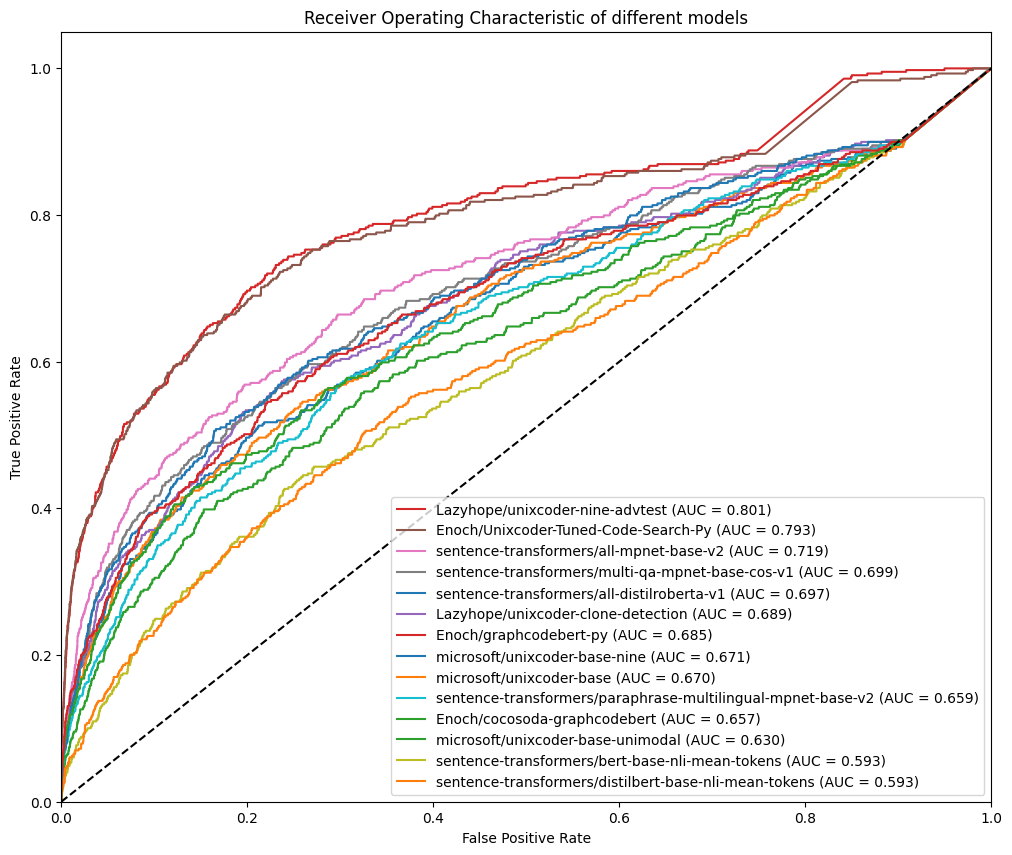

In [15]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


model_auc = {}
y_true = df['topic1'] == df['topic2']
fig = plt.figure(figsize=(12, 10))

def roc(model_name):
    y_score = df[model_name]
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    model_auc[model_name] = roc_auc

    plt.plot(fpr, tpr, label=model_name)

for model in models:
    roc(model)

# Order labels by each model's auc score
handles, labels = plt.gca().get_legend_handles_labels()
order = sorted(range(len(labels)), key=lambda k: -model_auc[labels[k]])
ordered_handles = [handles[idx] for idx in order]
ordered_labels = [f'{labels[idx]} (AUC = {model_auc[labels[idx]]:.3f})' for idx in order]
plt.legend(ordered_handles, ordered_labels, loc="lower right")

plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic of different models')
plt.savefig('roc_doc_evaluation_train_315.eps')
plt.show()

In [16]:
model_auc

{'microsoft/unixcoder-base-nine': 0.6711957795668481,
 'microsoft/unixcoder-base': 0.6696951249025659,
 'microsoft/unixcoder-base-unimodal': 0.6297370920734033,
 'Lazyhope/unixcoder-nine-advtest': 0.8005762510107144,
 'Lazyhope/unixcoder-clone-detection': 0.6893751823992921,
 'Enoch/Unixcoder-Tuned-Code-Search-Py': 0.7930968459055596,
 'sentence-transformers/all-mpnet-base-v2': 0.7189142633702663,
 'sentence-transformers/multi-qa-mpnet-base-cos-v1': 0.6985243403980401,
 'sentence-transformers/bert-base-nli-mean-tokens': 0.5927083597809336,
 'sentence-transformers/paraphrase-multilingual-mpnet-base-v2': 0.6593272377142161,
 'sentence-transformers/all-distilroberta-v1': 0.6970607955799487,
 'sentence-transformers/distilbert-base-nli-mean-tokens': 0.5925942963331288,
 'Enoch/cocosoda-graphcodebert': 0.6565882648063531,
 'Enoch/graphcodebert-py': 0.6850104606499172}